<a href="https://colab.research.google.com/github/IacobelliEmanuele/Dummy/blob/main/Modified_ESRGAN_for_solving_Super_Resolution_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Super Resolution Problem

The Image Super-Resolution problem is defined as the task of  enhancing the resolution of an image from low-resolution (LR) to high-resolution (HR).

This problem can be crucial in applications like:

- **Media / Streaming**: Saving only the LR version and then restore the HR when needed.
- **Security / Surveillance**: Having a better quality images from security cameras can led to better detections or identifications.
- **Medical**: Super-Resolution can help in the problem of capturing high-resolution MRI images.

In order to create a dataset, we have to artificially generate the LR images. This is possible by starting from the HR images and using a degradation function $D$ and some noise $\sigma$ (both unknown parameters):

$$
I_x = D(I_y\ ;\ \sigma)
$$

Where $I_x$ is the LR image and $I_y$ is the HR one.

The task of the neural network is to find $D^{-1}$ (the inverse function of the degradation) using as data the HR and LR images.

## <center> ![](https://drive.google.com/uc?id=17eaQFlxuvotdRHCMCPW5IgQGtSETnDXo)

# Libraries

All the libraries needed for our project.

In [ ]:
%%capture

import os
from pathlib import Path
import pandas as pd
import gdown
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import random
from typing import Tuple, Optional, Dict, List, Union, Callable, Any
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision import models
from torchvision.models.feature_extraction import create_feature_extractor

!pip install torchmetrics

from torchmetrics import functional, PeakSignalNoiseRatio
from torchmetrics.functional import peak_signal_noise_ratio as PSNR

!pip install torchinfo

!pip install  "pytorch-lightning==1.7.2"  
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger

# Download the project folder

In [ ]:
print("Downloading the project repository")
gdown.download(url='https://drive.google.com/uc?id=1LOvbz5RY64Ze_1sfymbJBg3lDM4SIO3g', output='DL-Project.zip', quiet=True)
print("Done.")

if os.path.exists("/content/DL-Project.zip"):
  with zipfile.ZipFile("DL-Project.zip", "r") as zip_ref:
    print(f"Unzipping files to DL-Project", end='\t')
    zip_ref.extractall()
    print("Done")
    os.remove("/content/DL-Project.zip")

Done.
Unzipping files to DL-Project	Done


# Auxiliary Functions

In this section of the notebook we have defined some auxiliary functions that we are going to use:

- `norm_zero_255()`: This function is used to normalize an image (in `torch.Tensor` format) from $[0,1]$ to $[0,255]$.
- `rotation()`: This function randomly drawn an angle from $\{0°, 90°, 180°, 270°\}$ and returns a `torchvision.transforms.RandomRotation()` function with that angle. 
- `display_random_images()`: This function displays 5 random images from the training, validation and testing datasets.
- `visualize_results()`: This function is used to show and plot the output of the models trained for this project with the corresponding value of PSNR.
- `read_train_csv()`: This function is used to read the metrics generated from the training of the models. The metrics are stored in csv files and this function organizes them in `Lists`.
- `read_val_csv()`: This function is used to read the metrics generated from the validation of the models. The metrics are stored in csv files and this function organizes them in `Lists`.
- `plot_generator_metrics()`: This function is used to plot the Generator metrics (training and validation).
- `plot_gan_metrics()`: This function is used to plot some metrics of the GAN (training and validation).

In [ ]:
def norm_zero_255(img: torch.Tensor) -> torch.Tensor:
  """This function takes as input an image in torch.Tensor format with values between [0,1] 
      and normalize it between [0,255].

  Args:
    - img (torch.Tensor): Image with values between [0,1] that has to be normalized between [0,255].

  Returns:
    - torch.Tensor: Normalized image between [0,255].
  """
  img = torch.mul(img,255.0)
  img = torch.round(img).float()
  return img

def rotation() -> transforms.RandomRotation:
  """The function returns a tranforms.RandomRotation of 0°, 90°, 180° or 270° degrees.

  Returns:
    - transforms.RandomRotation
  """
  rot_index = random.randint(0,3)
  rot_degrees = [0,90,180,270]
  rot_degree = rot_degrees[rot_index]
  return transforms.RandomRotation(degrees=(rot_degree, rot_degree))

def display_random_images(datamodule: pl.LightningDataModule,
                          display_shape: bool = True,
                          seed: int = None) -> None:
  """Given the datamodule containing the training, validation and testing datasets, 
        this function is used to display 5 random samples (both inputs and outputs) from each dataset.

  Args:
    - datamodule (pl.LightningDataModule): a pl.LightningDataModule object representing the datasets for the Super-Resolution task.
    - display_shape (bool): Flag used to display the shape of the images in the datasets. Default True.
    - seed (int): Seed used for random.sample(), for reproducibility pourposes. Default None.

  Returns:
    - None
  """
  
  #For reproducibility purposes
  pl.seed_everything(seed)
  torch.manual_seed(seed)
  random.seed(seed)

  train_data = datamodule.train_data
  val_data = datamodule.val_data
  test_data = datamodule.test_data
  
  len_train_data = len(train_data)
  len_val_data = len(val_data)
  len_test_data = len(test_data)

  print(f"Number of training images: {len_train_data}")

  # Generation of 5 random indices for displaying the training samples
  random_samples_idx = random.sample(range(len_train_data), k=5)
  
  # Creation of the plt figure for the training dataset
  plt.figure(figsize=(20, 10))
  plt.suptitle(f"Train: {len_train_data} images", fontsize=24)

  # Display 5 images for the training dataset
  for i, targ_sample in enumerate(random_samples_idx):
    input, output = train_data[targ_sample]
    input, output = input.permute(1, 2, 0), output.permute(1, 2, 0)

    plt.subplot(2, 5, i+1)
    plt.imshow(input)
    title = f"Input {i+1}"
    if display_shape:
      title = f"Input {i+1}\n{input.shape}"
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(output)
    title = f"Output {i+1}"
    if display_shape:
      title = f"Output {i+1}\n{output.shape}"
    plt.title(title, fontsize=16)
    plt.axis("off")

  print(f"Number of validation images: {len_val_data}")

  
  # Generation of 5 random indices for displaying the validation samples
  random_samples_idx = random.sample(range(len_val_data), k=5)
  # Creation of the plt figure for the validation dataset
  plt.figure(figsize=(20, 10))
  plt.suptitle(f"Validation: {len_val_data} images", fontsize=24)

  # Display 5 images for the validation dataset
  for i, targ_sample in enumerate(random_samples_idx):
    input, output = val_data[targ_sample]
    input, output = input.permute(1, 2, 0), output.permute(1, 2, 0)

    plt.subplot(2, 5, i+1)
    plt.imshow(input)
    title = f"Input {i+1}"
    if display_shape:
      title = f"Input {i+1}\n{input.shape}"
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(output)
    title = f"Output {i+1}"
    if display_shape:
      title = f"Output {i+1}\n{output.shape}"
    plt.title(title, fontsize=16)
    plt.axis("off")

  print(f"Number of testing images: {len_test_data}")

  # Generation of 5 random indices for displaying the testing samples
  random_samples_idx = random.sample(range(len_test_data), k=5)
  # Creation of the plt figure for the testing dataset
  plt.figure(figsize=(20, 10))
  plt.suptitle(f"Test: {len_test_data} images", fontsize=24)
  # Display 5 images for the testing dataset
  for i, targ_sample in enumerate(random_samples_idx):
    input, output = test_data[targ_sample]
    input, output = input.permute(1, 2, 0), output.permute(1, 2, 0)

    plt.subplot(2, 5, i+1)
    plt.imshow(input)
    title = f"Input {i+1}"
    if display_shape:
      title = f"Input {i+1}\n{input.shape}"
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(output)
    title = f"Output {i+1}"
    if display_shape:
      title = f"Output {i+1}\n{output.shape}"
    plt.title(title, fontsize=16)
    plt.axis("off")
  
  plt.show()

def visualize_results(datamodule: pl.LightningDataModule,
                      methods: Dict):
  """A function used to visualize the results on a common random test data of the methods proved inside the 'methods' dictionary given as input.

  Args:
    - datamodule (pl.LightningDataModule): The data module containing the test data.
    - methods (Dict): A dict containing all the other methods beside the ground truth (GT) and bicubib interpolation.

  Returns:
    - psnr_dic (Dict): A dict containing the psnr values of the models in the dictionary 'methods' and the bicubic interpolation. 
  """
  sns.reset_orig()
  data = datamodule.test_data
  total = 3 + len(methods)

  random_samples_idx = random.sample(range(len(data)), k=5)
  plt.figure(figsize=(5*total, 30))
  n = 1

  psnr_dic = {}
  
  psnr_dic['Bicubic'] = 0
  for method_name in methods:
    model = methods[method_name]
    model.eval()
    psnr_dic[method_name] = 0

  for i, targ_sample in enumerate(random_samples_idx):
    inp, output = data[targ_sample][0], data[targ_sample][1].permute(1, 2, 0)
    bicubic_img = bicubic(inp).permute(1, 2, 0)

    input = inp.permute(1, 2, 0)
    
    plt.subplot(5, total, n)
    plt.imshow(input)
    title = f"Input Image: {i+1}\nShape: {list(input.shape)}"
    plt.title(title, fontsize=16)
    plt.axis("off")

    plt.subplot(5, total, n+1)
    plt.imshow(output)
    title = f"GT Image: {i+1}\n{list(output.shape)}"
    plt.title(title, fontsize=16)
    plt.axis("off")
    
    bic_psnr = PSNR(norm_zero_255(bicubic(inp)),norm_zero_255(data[targ_sample][1])).item()
    psnr_dic['Bicubic'] += bic_psnr

    plt.subplot(5, total, n+2)
    plt.imshow(bicubic_img)
    title = f"Bicubic Image: {i+1}\nShape: {list(bicubic_img.shape)}"
    plt.xlabel('PSNR: '+str(bic_psnr))
    plt.title(title, fontsize=16)
    plt.axis("on")

    with torch.inference_mode():
      for j, method in enumerate(methods):
    
        model = methods[method].to('cuda')
        out = data[targ_sample][1].to('cuda')
        method_img =  model( inp.unsqueeze(dim=0).to('cuda') ).squeeze(dim=0).permute(1, 2, 0).detach().cpu()
        psnr = PSNR(norm_zero_255( model( inp.unsqueeze(dim=0).to('cuda') )), norm_zero_255( out ) ).item()
        psnr_dic[method] = psnr_dic[method] + psnr
        plt.subplot(5, total, n+3+j)
        plt.imshow(method_img)
        plt.xlabel('PSNR: '+str(psnr))
        title = f"{method} Image: {i+1}\nShape: {list(method_img.shape)}"
        plt.title(title, fontsize=16)
        plt.axis("on")
        
        model.to('cpu')
        out.to('cpu')    
    
    n+=total
  plt.show()
    
  print('')

  for method in psnr_dic:
    psnr_dic[method] = psnr_dic[method]/5

  plt.show()

  return psnr_dic

def read_train_csv(files: List[str],
                   labels: List[str]) -> Tuple[List[np.array], List[np.array]]:
  """Function used to read train metrics from csv file into data structure.

  Args:
    - files (List[str]): List of paths to .csv file containing metrics data.
    - labels (List[str]): List of column names that has to be extracted from the .csv file.

  Returns:
    - Tuple[List[np.array], List[np.array]] : A tuple containing the cleaned train metrics.
  """

  # Initialization of the lists containing the values inside the .csv files
  train_loss_values = []
  train_step_values = []
  
  # Initialization of the arrays containing the values to be plotted
  final_train_values = np.array([], dtype=int)
  final_train_steps = np.array([], dtype=int)

  # Extract the data from each .csv file
  for file in files:
      
    df = pd.read_csv(file, keep_default_na=False)
    
    train_data = df.loc[:,labels]
    train_data = train_data[train_data[labels[0]] != '']

    train_loss_values.append( np.asarray(train_data[labels[0]].tolist(), dtype=float) )
    train_step_values.append( np.asarray(train_data[labels[1]].tolist(), dtype=int) )

  # Concatenate the data
  for i in range(0,len(train_step_values)-1):
    index = np.where(train_step_values[i] == train_step_values[i+1][0])[0][0]
    final_train_values = np.concatenate( (final_train_values, train_loss_values[i][:index]) )
    final_train_steps = np.concatenate( (final_train_steps, train_step_values[i][:index]) )
  final_train_values = np.concatenate( (final_train_values, train_loss_values[-1]) )
  final_train_steps = np.concatenate( (final_train_steps, train_step_values[-1]) )
    
  return [final_train_steps, final_train_values]

def read_val_csv(files: List[str],
                 labels: List[str]) -> Tuple[List[np.array], List[np.array]]:
  """Function used to read validation metrics from csv file into data structure.

  Args:
    - files (List[str]): List of paths to .csv file containing metrics data.
    - labels (List[str]): List of column names that has to be extracted from the .csv file.

  Returns:
    - Tuple[List[np.array], List[np.array]] : A tuple containing the cleaned validation metrics.
  """

  # Initialization of the lists containing the values inside the .csv files
  val_loss_values = []
  val_step_values = []
  
  # Initialization of the arrays containing the values to be plotted
  final_val_values = np.array([], dtype=int)
  final_val_steps = np.array([], dtype=int)

  # Extract the data from each .csv file
  for file in files:
      
    df = pd.read_csv(file, keep_default_na=False)
    
    val_data = df.loc[:,labels]
    val_data = val_data[val_data[labels[0]] != '']

    val_loss_values.append( np.asarray(val_data[labels[0]].tolist(), dtype=float) )
    val_step_values.append( np.asarray(val_data[labels[1]].tolist(), dtype=int) )

  # Concatenate the data
  for i in range(0,len(val_loss_values)):
    final_val_values = np.concatenate( (final_val_values, val_loss_values[i]) )
    final_val_steps = np.concatenate( (final_val_steps, val_step_values[i]) )
    
  return [final_val_steps, final_val_values]

def plot_generator_metrics(train_steps_gen: np.array,
                 train_values_gen: np.array,
                 val_step_gen: np.array,
                 val_loss_gen: np.array,
                 mark_list: List[int] = None) -> None:
  """Function used to visualize the Generator metrics values as a line plot.

  Args:
    - train_steps_gen (np.array): The train steps.
    - train_values_gen (np.array): The value of the train metric for each step.
    - val_step_gen (np.array): The validation steps.
    - val_loss_gen (np.array): The validation values.
    - mark_list (List[int]): List containing the index of the validation steps which correspond to the end of the epochs.

  Returns:
    - None
  """
    
  # Apply the default theme
  sns.set_theme()
  
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(train_steps_gen, train_values_gen, lw=1.2, color='b')
  plt.title('Training plot for Generator')
  plt.xlabel('Steps')
  plt.ylabel('L1 Loss Values')

  plt.subplot(1, 2, 2)
  plt.plot(val_step_gen, val_loss_gen, lw=1.2, color='r', marker='o', markevery=mark_list)
  plt.title('Validation plot for Generator')
  plt.xlabel('Steps')
  plt.ylabel('L1 Loss')

  plt.show()

def plot_gan_metrics(train_steps1: np.array,
                    train_values1: np.array,
                    train_steps2: np.array,
                    train_values2: np.array,
                    train_steps3: np.array,
                    train_values3: np.array,
                    train_steps4: np.array,
                    train_values4: np.array,
                    val_steps: np.array,
                    val_values: np.array,
                    mark_list: List[int] = None) -> None:
  """Function used to visualize the GAN metrics values as a line plot.

  Args:
    - train_steps1 (np.array): The train steps for the first metric.
    - train_values1 (np.array): The values of the first metric.
    - train_steps2 (np.array): The train steps for the second metric.
    - train_values2 (np.array): The values of the second metric.
    - train_steps3 (np.array): The train steps for the third metric.
    - train_values3 (np.array): The values of the third metric.
    - train_steps4 (np.array): The train steps for the fourth metric.
    - train_values4 (np.array): The values of the fourth metric.
    - val_steps (np.array): The validation steps.
    - val_values (np.array): The validation values.
    - mark_list (List[int]): List containing the index of the validation steps which correspond to the end of the epochs.
    
  Returns:
    - None
  """
    
  # Apply the default theme
  sns.set_theme()
  
  plt.figure(figsize=(20, 5))

  plt.subplot(1, 3, 1)
  plt.plot(train_steps1, train_values1, lw=1.2, color='r', label='Generator Loss')
  plt.plot(train_steps2, train_values2, lw=1.2, color='b', label='Discriminator Loss')
  plt.title('Generator-Discriminator Losses')
  plt.xlabel('Steps')
  plt.ylabel('Loss Values')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=2)

  plt.subplot(1, 3, 2)
  plt.plot(train_steps3, train_values3, lw=1.2, color='r', label='Generator Loss')
  plt.plot(train_steps4, train_values4, lw=1.2, color='b', label='Discriminator Loss')
  plt.title('Wasserstein Generator-Discriminator Losses')
  plt.xlabel('Steps')
  plt.ylabel('Loss Values')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=2)

  plt.subplot(1, 3, 3)
  plt.plot(val_steps, val_values, lw=1.2, color='g', marker='o', markevery=mark_list)
  plt.title('Validation plot for GAN')
  plt.xlabel('Steps')
  plt.ylabel('PSNR Values')
  
  
  plt.show()

# Principal Datasets Used

In order to solve the Super-Resolution task we have used the following datasets (which have been utilized in several articles dealing with the Super-Resolution task): 

1. The [DIV2K dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/). It is composed of 1000 RGB 2K resolution images divided in: 800 for training, 100 for evaluation and 100 for testing.
2. The [Set5 dataset](http://people.rennes.inria.fr/Aline.Roumy/results/SR_BMVC12.html) (commonly used for testing the performances of Image Super-Resolution models). It is composed of 5 RGB images with different resolutions. 

In particular, we have used the training and validation datasets from the DIV2K and as testing dataset the Set5.

# Data Preprocessing

For the training and validation datasets we have used a square sliding window (224x224 pixels) that has divided the training images into overlapping patches and the validation images into non overlapping patches. In detail, we have used a step of 112 pixels for the training dataset and step of 224 pixels for the validation dataset.

In order to save the available gpu time of google coolab and avoiding redundant computations, we decided to perform this pre-processing step externally. The obtained images have been zipped and uploaded on google drive, so that they can be quickly downloaded at the beginning of each new session.

Examples of the training and validation images that we have generated from the DIV2K dataset:

## <center> **Original Training Image**: 

## <center> ![](https://drive.google.com/uc?id=1iATauZwEpKXczTXvesg8R6ciQIkRgEvZ)

## <center> **Some of the generated Training Images:**


## <center> ![](https://drive.google.com/uc?id=1PIC2uot7geaN0OXa8DWncaxqwpZ3ipj0) ![](https://drive.google.com/uc?id=1F9nqNzlBA2wmGK4IBGRQAMPhVlflWVK3) ![](https://drive.google.com/uc?id=1YfRnqR6Q2uES9zvYOZRbAHBkyiiCkVbp) ![](https://drive.google.com/uc?id=1VoQHGDvdY2LzmAlrvBHp4gIFcrSOo_Ea) ![](https://drive.google.com/uc?id=1w32zhfMA2NLLAu8lu0EabBNdB8xs-4oi) ![](https://drive.google.com/uc?id=1Y8ADlCLWS8Y8VLuW7uCvkXMG1KwhJh8r) ![](https://drive.google.com/uc?id=1Jzc6XA5B5Y7L6y_7DPDy2DBdg76k-VXG) ![](https://drive.google.com/uc?id=1_UPoy82JLe2YTa2cCDapCnLpvCB7FP5D) ![](https://drive.google.com/uc?id=13NrjIUt-nZd9pltJMYTgxJQ2UvUIvldI) ![](https://drive.google.com/uc?id=1b6e2XXEpjHU1aRi7KlvQMIX_rv8tSJln) ![](https://drive.google.com/uc?id=1XolFgelqhir-0pVl9xd1uMOPJgpjRCq8) ![](https://drive.google.com/uc?id=136MFabRn0U3p5dtlV6Mi5sNJqneD6m1u) ![](https://drive.google.com/uc?id=16Q4SZ7mM1qPFz6eGQ6H8jsvgti1701c_) ![](https://drive.google.com/uc?id=1OHC05bzny9TZn4t9ac_HAuC7jx8ZI0fo) ![](https://drive.google.com/uc?id=1sTC8AH70mYBP3QVE7d73pA9Dnum5d-0u) ![](https://drive.google.com/uc?id=1FVAHs0dgVY3ec0ctI9HuZkE3YbsO0o5C)

## <center> **Original Validation Image**: 

## <center> ![](https://drive.google.com/uc?id=1o5JAPacJZiYobGmIAXUl9rhB7v1yjTdB)

## <center> **Some of the generated Validation Images:**

## <center> ![](https://drive.google.com/uc?id=1mgdGaC4Fpnm-PPypu11aoER1TyzO1deV) ![](https://drive.google.com/uc?id=1_qOXx_aqxOf-3ThevLl9QQpowHH0Sp_X) ![](https://drive.google.com/uc?id=15b076SisntveU-5YivamnsD4stRBJwPZ) ![](https://drive.google.com/uc?id=1JkX1QZ6DaXhLvMjEaFpl-qeamdaYPq7O) ![](https://drive.google.com/uc?id=1wvSjbQc3hlJ0v4CTMukOqDyhcD3Oy6zH) ![](https://drive.google.com/uc?id=1T4kL91vMZ2wZHmkODXD1Vq11-TPFPnAm) ![](https://drive.google.com/uc?id=1I4dASKNuDPDqPKhhg1-jfdpMjzGpYuIA) ![](https://drive.google.com/uc?id=1iaYZxKs1OpCdnkx5d2_J2-4S2ZR5uOW4) ![](https://drive.google.com/uc?id=1-drLYDCZY4qIYVKUHkrhigGcIsiK1rCf)

# Pytorch LightningDataModule

In order to download and load the images that we have generated, we have used `pl.LightningDataModule` ([DataModule](https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html)) which is composed by 3 principal sections:

- `prepare_data()`: we download the datasets from google drive, we unzip them and we eliminate the .zip files in order to minimize the disk usage.
- `setup()`: we initialize each dataset by calling the `ImageFolderCustom()` function with the corresponding list of transformations.
- **Dataloader Section**: we initialize the train/validation/test dataloaders.

In order to perform data augmentation, for the training and validationd datasets we have defined the following list of `torchvision.transforms` transformations:

- `transforms.ToTensor()`
- `transforms.RandomCrop(128)`
- `transforms.RandomHorizontalFlip(0.5)`
- `rotation()`
- `transforms.RandomVerticalFlip(0.5)`

Taking as example the following image, we explain the data augmentation process:

## <center> ![](https://drive.google.com/uc?id=1GLpdjvXo7_2j3bqOYkKX6zorQ-K1xURp)

First of all, the image is loaded by using PIL and it is converted to the `torch.Tensor` format (the image is normalized between [0,1]). Subsequently, a `RandomCrop(128)` is applied, so that the size of the image is reduced from 224x224 pixels to 128x128 pixels.

## <center> ![](https://drive.google.com/uc?id=130p0k48bLxZM69OyZWWXHZPkeM8D5hm5)

Then, with a probability of 0.5, we perform a `RandomHorizontalFlip()` which flips the image horizontally. In average, half of the training and validation images are the "mirror versions" of the originals.

## <center> ![](https://drive.google.com/uc?id=1cnlXS5yrFqBkyZjDNvGIwEzmufXLTWKl)

After that, the `rotation()` function is applied. It randomly pick an angle between $\{0,90,180,270\}$ and applies a rotation with the that angle. 

## <center> ![](https://drive.google.com/uc?id=1Z0282KVPML0mWFR2mvRcHmEf0FuDBa4K)

Finally,  with a probability of 0.5, we perform a `RandomVerticalFlip()` that flips the image vertically. In average, half of the training and validation images are the upside-down version of the originals.

## <center> ![](https://drive.google.com/uc?id=1j6BQk02agGXo2JeY6UckUQiyWq-v5vL_)

# Pytorch Datasets

In order to easily handle the datasets, we have implemented a custom version of the `torchvision.datasets.ImageFolder` class ([ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)):

- `ImageFolderCustom()`: The main differences with the classic implementation are:
 - The presence of multiple target directories since we had to save the training and validation data in two different folders for memory/computational issues.
 - The usage of a scale parameter for the generation of the models' input images.

In particular, the models' input images are obtained by downscaling the images  inside the target directories given as input to the ImageFolderCustom class.  

To downscale the images, we have tried different interpolations:
- **Bilinear**, **Bicubic** and **Nearest** implemented with `torchvision.transforms.Resize()`. 
- **Bicubic** and **Area** implemented with Opencv by using `cv2.resize()` ( the bicubic interpolation has beed tested only to check if there were differences compared to the torchvision implementation).

We show the differences between the different interpolations: 

## Original Image (344x228):

## <center> ![](https://drive.google.com/uc?id=1t0h9PQvxnLd7yw8bsYOqDn3yJqUg_crm)


## Downsampled Images (86x57):

## <center> ![](https://drive.google.com/uc?id=14wyVF6Id-fSEdrHQQ15mkZfStcZ2CepT)

After some considerations we have decided that the best downsampling interpolation to use was the **Area** from Opencv.

In [ ]:
class ImageFolderCustom(Dataset):
  """A custom implementation of the torchvision.datasets.ImageFolder() class.

  Args:
    - targ_dir1 (str): The first target directory where the data is stored.
    - targ_dir2 (str): The second target directory where the data is stored. Dafault: None.
    - transform (torchvision.transforms): A transformation to apply to the data. Default: None.
    - scale (int): The scale between the input and the output. Default: 4.

  Attributes:
    - path1 (List[str]): A list of the *.png files find in the directory targ_dir1.
    - path2 (List[str]): A list of the *.png files find in the directory targ_dir2. Default: Empty List.
    - paths (List[str]): The concatenated list defined as path1+path2.
    - transform (torchvision.transforms): The variable in which we save the arg transform.
    - scale: The variable in which we save the arg scale.
  """
  def __init__(self,
               targ_dir1: str,
               targ_dir2: str = None,
               transform: transforms = None,
               scale: int = 4) -> None:
    self.path1 = list(Path(targ_dir1).glob("*.png"))
    if targ_dir2:
      self.path2 = list(Path(targ_dir2).glob("*.png"))
    else:
      self.path2 = []
    self.paths = self.path1 + self.path2
    self.transform = transform
    self.scale = scale

  def load_image(self, index: int) -> Image.Image:
    """Load image at the index from self.paths.

    Args
      - index (int): The image index.

    Returns:
      - Image.Image : The actual self.paths[index] image in PIL format.
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    """A function that returns the lenght of the dataset.

    Returns:
      - int : The lenght.
    """
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """The function that returns the images (input and output) at a given index.
    The input version is generated from the output using cv.resize() with interpolation=cv.INTER_AREA.

    Args:
      - index (int): The index of the image to return.

    Returns:
      - res_img, img (Tuple[torch.Tensor, torch.Tensor]): The tuple of the input and output image.
    """
    img = self.load_image(index)
    
    if self.transform:
      img = self.transform(img)
    else:
      img = transforms.ToTensor()(img)

    img_cv = np.asarray( transforms.ToPILImage()(img) )
    img_cv = cv.resize(img_cv,((int(img_cv.shape[1] / self.scale), int(img_cv.shape[0] / self.scale))), interpolation=cv.INTER_AREA)
    res_img = transforms.ToTensor()(Image.fromarray(img_cv))

    return res_img, img
    
class DataModule(pl.LightningDataModule):
  """Our pl.LightningDataModule implementation for our dataset.

  Args:
    - data_dir1 (str): the path where to find the train1 and val data.
    - data_dir2 (str): the path where to find the train2 data.
    - data_dir3 (str): the path where to find the test data (Set5).
    - batch_size (int): the batch size used for the train and validation DataLoader. Default 16.
    - num_workers (int): number of workers to pass to the dataloaders. Default None.
  
  Attributes:
    - data_dir1 (str): The variable in which we store the arg data_dir1 value.
    - data_dir2 (str): The variable in which we store the arg data_dir2 value.
    - data_dir3 (str): The variable in which we store the arg data_dir3 value.
    - train_data  (Dataset): The train dataset taken using ImageFolderCustom on data_dir1 and on data_dir2.
    - val_data (Dataset): The validation dataset taken using ImageFolderCustom on data_dir1.
    - test_data (Dataset): The test dataset taken using ImageFolderCustom on data_dir3.
    - batch_size (int): The variable in which we save the arg batch_size.
    - num_workers (int): The variable in which we save the arg num_workers.
    - transform (torchvision.transforms.Compose): A composition of defined transformations to apply to the train and validation data.
  """
  def __init__(self,
               data_dir1: str,
               data_dir2: str,
               data_dir3: str,
               batch_size: int = 16,
               num_workers: int = 0) -> None:
    super().__init__()
    self.data_dir1 = data_dir1
    self.data_dir2 = data_dir2
    self.data_dir3 = data_dir3
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.batch_size = batch_size
    self.num_workers = num_workers 

    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(128),
        transforms.RandomHorizontalFlip(0.5),
        rotation(),
        transforms.RandomVerticalFlip(0.5)
    ])

  def prepare_data(self) -> None:
    """The function used to download the datasets.

    Returns:
      - None
    """
    SR_data1 = self.data_dir1
    SR_data2 = self.data_dir2
    Set5_data = self.data_dir3

    if SR_data1.is_dir():
      print("SR_data1 data is already downloaded, skipping download.")

    else:
      print("SR_data1 data not found. Starting the download:")
      print("Downloading SR_data1 data...", end='\t\t')     


      gdown.download(url='https://drive.google.com/uc?id=12jIrLoXDMzrnzq8GZnjBoZlAvMTUnTwv', output='SR-Dataset1.zip', quiet=False)
      #If the first link gives problem during the download due to Google Drive Limitations, use the following link:
      #gdown.download(url='https://drive.google.com/uc?id=1hrdv4PsXRBKsxY7sOE8aB1pntVTg_w-_', output='SR-Dataset1.zip', quiet=False)

      print("Done")

    if SR_data2.is_dir():
      print("SR_data2 data is already downloaded, skipping download.")

    else:
      print("Data not found. Starting the download:")
      print("Downloading SR_data2 data...", end='\t\t') 

      gdown.download(url='https://drive.google.com/uc?id=1xuFmUwVwCAkikk5rV8HwSxehT6SB4E8l', output='SR-Dataset2.zip', quiet=False)
      #If the first link gives problem during the download due to Google Drive Limitations, use the following link:
      #gdown.download(url='https://drive.google.com/uc?id=1jRkcGifyZW6jpkz1G6u1g9Cs9krohKWz', output='SR-Dataset2.zip', quiet=False)

      print("Done")

    if Set5_data.is_dir():
      print("Set5 data is already downloaded, skipping download.")

    else:
      print("Set5 data not found. Starting the download:")
      print("Downloading the Set5 data...", end='\t\t')
      gdown.download(url='https://drive.google.com/uc?id=12IN1bsNwIGqQyR-fB2m38Q-dniTHp3pF', output='Set5.zip', quiet=True)
      print("Done")

    if os.path.exists("/content/SR-Dataset1.zip"):
      with zipfile.ZipFile("SR-Dataset1.zip", "r") as zip_ref:
        print(f"Unzipping SR_data1 data to {self.data_dir1}", end='\t')
        zip_ref.extractall(self.data_dir1)
        print("Done")
        os.remove("/content/SR-Dataset1.zip")

    if os.path.exists("/content/SR-Dataset2.zip"):
      with zipfile.ZipFile("SR-Dataset2.zip", "r") as zip_ref:
        print(f"Unzipping SR_data2 data to {self.data_dir2}", end='\t')
        zip_ref.extractall(self.data_dir2)
        print("Done")
        os.remove("/content/SR-Dataset2.zip")

    if os.path.exists("/content/Set5.zip"):
      with zipfile.ZipFile("Set5.zip", "r") as zip_ref:
        print(f"Unzipping Set5 data to {self.data_dir3}", end='\t')
        zip_ref.extractall(self.data_dir3)
        print("Done")
        os.remove("/content/Set5.zip")

  def setup(self) -> None:
    """The function in which we define each dataset using our ImageFolderCustom.

    Returns:
      - None
    """
    
    if self.train_data == None:
      self.train_data = ImageFolderCustom(targ_dir1 = self.data_dir1 / "train1", targ_dir2 = self.data_dir2 / "train2", transform=self.transform)

    if self.val_data == None:
      self.val_data = ImageFolderCustom(targ_dir1 = self.data_dir1 / "valid", transform=self.transform)
                                        
    if self.test_data == None:
      self.test_data = ImageFolderCustom(targ_dir1=self.data_dir3)

  def train_dataloader(self) -> torch.utils.data.DataLoader:
    """The function used to return the train DataLoader.

    Returns:
      - torch.utils.data.DataLoader : the train DataLoader.
    """
    return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

  def val_dataloader(self) -> torch.utils.data.DataLoader:
    """The function used to return the validation DataLoader.

    Returns:
      - torch.utils.data.DataLoader : the validation DataLoader.
    """
    return DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

  def test_dataloader(self) -> torch.utils.data.DataLoader:
    """The function used to return the test DataLoader.

    Returns:
      - torch.utils.data.DataLoader : the test DataLoader.
    """
    return DataLoader(self.test_data, shuffle=False, num_workers=self.num_workers)

# Initialization of the Datasets and some example images.


INFO:pytorch_lightning.utilities.seed:Global seed set to 44


SR_data1 data not found. Starting the download:

Downloading...
From: https://drive.google.com/uc?id=12jIrLoXDMzrnzq8GZnjBoZlAvMTUnTwv
To: /content/SR-Dataset1.zip
100%|██████████| 6.79G/6.79G [01:50<00:00, 61.6MB/s]


Done
Data not found. Starting the download:

Downloading...
From: https://drive.google.com/uc?id=1xuFmUwVwCAkikk5rV8HwSxehT6SB4E8l
To: /content/SR-Dataset2.zip
100%|██████████| 6.47G/6.47G [01:12<00:00, 88.9MB/s]


Done
Set5 data not found. Starting the download:
Unzipping SR_data1 data to SR-data1	Done
Unzipping SR_data2 data to SR-data2	Done
Unzipping Set5 data to Set5	Done


INFO:pytorch_lightning.utilities.seed:Global seed set to 44


Number of training images: 148716
Number of validation images: 5364
Number of testing images: 5


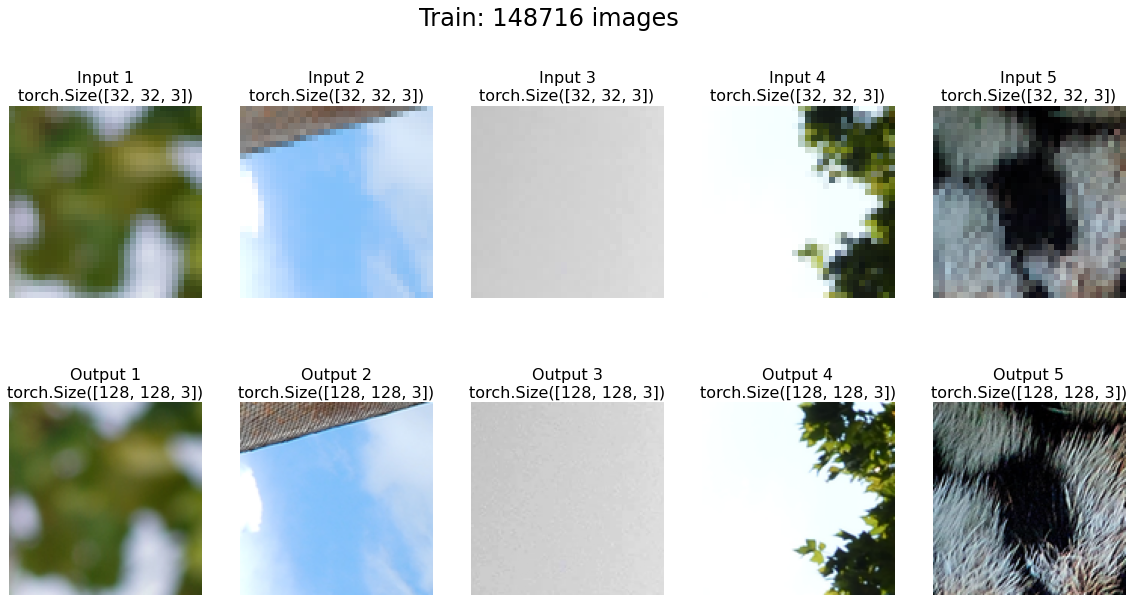

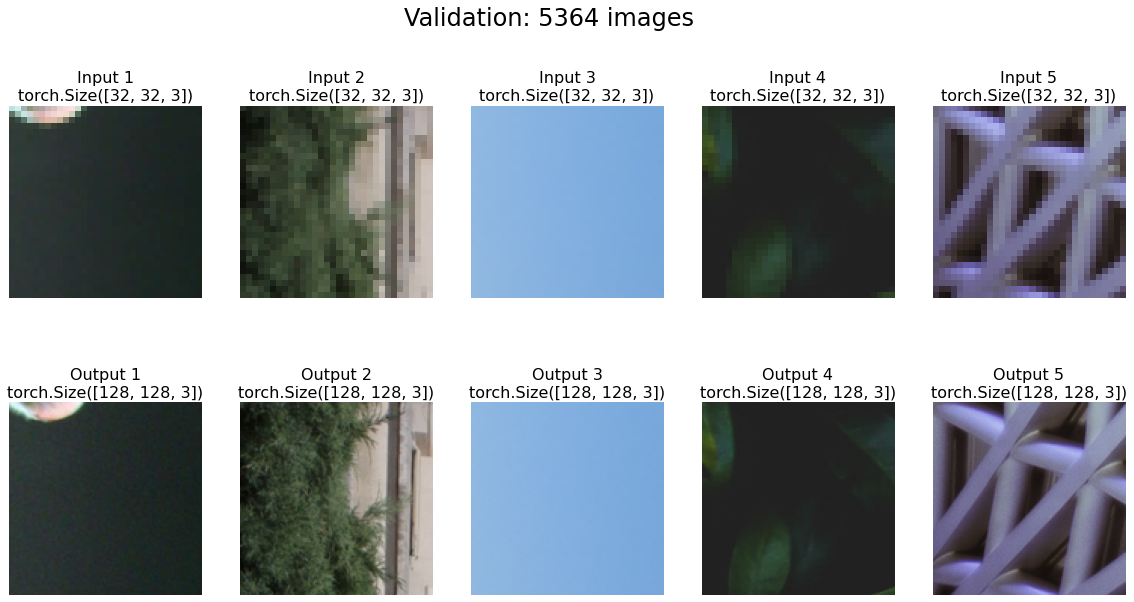

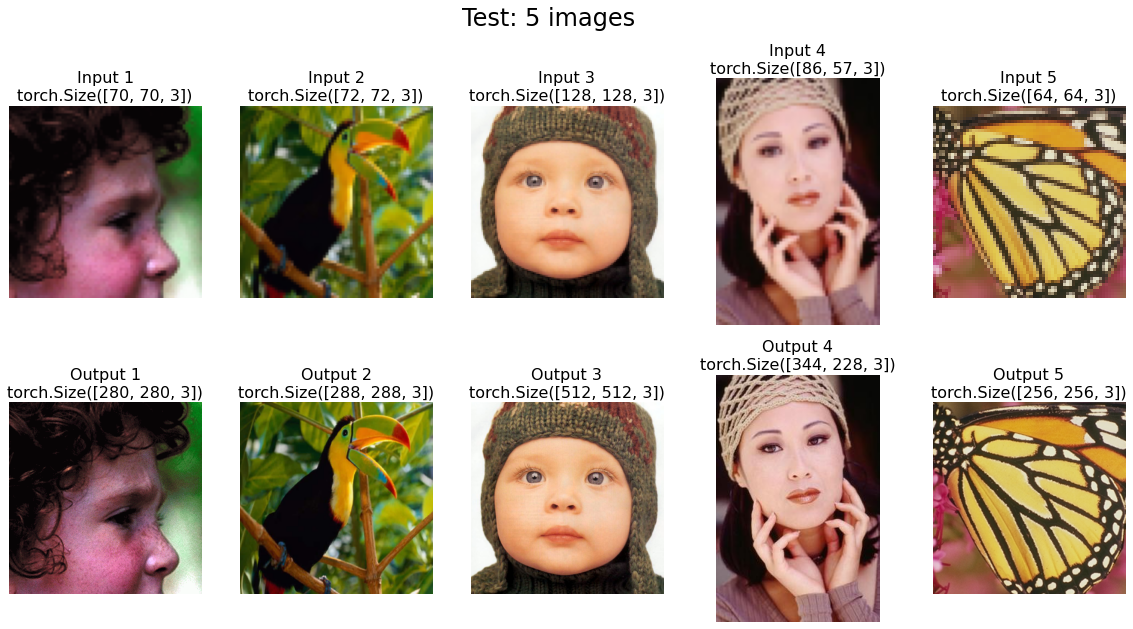

In [ ]:
seed = 44
pl.seed_everything(seed)
random.seed(seed)
torch.manual_seed(seed)

DIV2K_path1 = Path("SR-data1/")
DIV2K_path2 = Path("SR-data2/")
Set5_path = Path("Set5/")
datasets = DataModule(DIV2K_path1, DIV2K_path2, Set5_path)
datasets.prepare_data()
datasets.setup()

display_random_images(datasets, seed=seed)

# Baseline Models

## Bicubic Interpolation

The bicubic interpolation is one of the most common algorithms used for scaling images in computer vision in the recent years. The main idea is to interpolate the intensity value of the pixels basing on cubic polynomials. The cubic interpolation is computed taking into account the gradient of the neighbors pixels of the one that has to be sampled (the red circle in the image below). These gradients are computed considering the two extrernal pixels to the neighbors pixels. For this reason the bicubic interpolation uses kernels of dimention 4x4. 

<img src="https://drive.google.com/uc?id=1_aTrIjRxAAFHVB6clnXDjj2CMDN_bcHU" width="500"/>



In [ ]:
def bicubic(img: torch.Tensor,
            scale: int = 4) -> torch.Tensor:
  """This fuction returns the scaled version of the input torch.Tensor() image applying a bicubic interpolation.
  Args:
    - img (torch.Tensor): the input image.
    - scale (int): the scaling factor. Default: 4.

  Returns:
    - torch.Tensor : A scaled version of the input image in torch.Tensor format.
  """
  scaled_shape = (img.shape[1]*scale, img.shape[2]*scale)
  bicubic = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(scaled_shape, interpolation=InterpolationMode.BICUBIC),
      transforms.ToTensor()
  ])
  return bicubic(img)

## ESRGAN 

The [**Enhanced Super Resolution Generative Adversarial Network (ESRGAN)**](https://arxiv.org/abs/1809.00219) by Wang et al. is an improvement of the [**Super Resolution Generative Adversarial Network (SRGAN)**](https://arxiv.org/abs/1609.04802) proposed by Ledig et al. 

The SRGAN is composed of two main networks, the generator and the discriminator. 

### Generator (SRResNet):

The generator is composed of 3 main steps: 

- **Shallow Feature Extraction network**: Composed of a convolution layer which increases the number of channels of the input image. 
- **Deep Feature Extraction network**: Composed of a series of [*Residual Blocks*](https://arxiv.org/abs/1512.03385) with skip connections. 
- **Upscale network**: Composed of two PixelShuffle layers which increase the dimention of the input up to x4. 

#<center> ![](https://drive.google.com/uc?id=1VVl8Qzx9aWlusnxPnsKDor9ixQrTVTNX)

### Discriminator:

- **Shallow Feature Extraction Network**: Composed of a convolution layer which increases the number of channels of the input image. 
- Eight convolutional layers with an increasing number of 3 × 3 filter kernels, increasing by a factor of 2 from 64 to 512 kernels as in the VGG network. Strided convolutions are used to reduce the image resolution each time the number of features is doubled.
- The resulting 512 feature maps are followed by two dense layers (1024 and 1 hidden units, respectively) and a final sigmoid activation function to obtain a probability for sample classification.

#<center> ![](https://drive.google.com/uc?id=1ZoS602CqGFREUGh4tPnAx1Aa9aUFPbN5)

### Loss Functions: 

In order to train the GAN, the SRGAN uses the **Perceptual Loss**. It is defined as the weight sum of the following two loss functions: 

#<center> ![](https://drive.google.com/uc?id=1ghZ66gD3OG179IlxZ4nfbpZ0bRaYi0ib)

- **Content Loss**: Also called VGG loss, it is based on the ReLU activation layers of the pre-trained VGG19 network. In generale, $\phi_{i,j}$ indicates the feature map obtained by the j-th convolution (after activation) before the i-th maxpooling layer within the VGG19 network. The Content Loss is computed as the distance between the feature representations of the image created by the generator and the original image.   

#<center> ![](https://drive.google.com/uc?id=1CTZOXrW65vvvo2uNAr3gIP08uNthrX_u)

- **Generative Loss**: Also called GAN/Adversarial loss, it estimates the probability that the generated image is real and natural.

#<center> ![](https://drive.google.com/uc?id=1lReDbDcOm10dhxaTIr8vfRxCvwdH9-iv)

## ESRGAN Improvements

The principal improvements proposed by the ESRGAN regard the replacement, inside the generator, of the **Residual Dense Blocks** with the **Residual in Residual Dense Blocks** and the enhancement of the Discriminator based on the [**Relativistic average Discriminator (RaD)**](https://arxiv.org/abs/1807.00734). In detail: 

## ESRGAN Generator: 

The ESRGAN generator maintains the shallow feature extraction and the upscaling networks unchanged while improves the deep feature extraction network. Specifically:
- The **batch normalization layers** are removed, since they could generate unpleasent artifacts in addition to save computational resources and memory usage in deep networks. 
- The **residual scalings** are introduced to speed up the training of deep networks.
- The **Residual Dense Blocks** are replaced with the **Residual in Residal Dense Blocks**, in which the input of the ith layer is obtained by concatenating the input and the output of the ith - 1 layer. 

#<center> ![](https://drive.google.com/uc?id=1WL-UF5h1lnI7JpfpstDcfogUWkn0NGvR)

#<center> ![](https://drive.google.com/uc?id=11YXU_1hBYugEcqyccujUzOzk9fvpwAJy)

## ESRGAN Discriminator: 

### Adversarial Loss: 

The structure of the discriminator remains the same but differently from the SRGAN's adversarial loss, which estimates the probability that the input image is real and natural, the **Relativistic Discriminator loss** tries to predict the probability that an image is more realistic than another. Specifically, the **Relativistic average Discriminator** compares in turns the fake image with the average of the real data mini-batch and vice-versa. 

#<center> ![](https://drive.google.com/uc?id=1PFooSTjRihZa5AWhhJnPsYwzUNB1QnRS)

### ESRGAN Perceptual Loss: 

The SRGAN's perceptual loss is defined on the activation layers of a pre-trained deep network (VGG19) where the distance between two activated features is minimized. On the contrary the authors of ESRGAN propose to use features before the activation layers. This modification, overcomes two drawbacks of the SRGAN design: 

- The activated features are very sparse and provides weak supervision and leads to inferior performance. 
- Using features after activation, causes inconsistent reconstructed brightness compared with the ground-truth image.

## ESRGAN Total Loss: 

The Total loss used by the ESRGAN is the weighted average the pixel loss (L1 loss) and the already mentioned adversarial and perpectual loss.

#<center> ![](https://drive.google.com/uc?id=1DV-juB2byAyW24cIlsf68VsFoDsshQXD)



### Generator

In [ ]:
class ResBlock(nn.Module):
  """Residual Dense Block.
  Args:
    - in_channels (int): The number of input channels for each conv in the residual dense block.
    - out_channels (int): The number of output channels for each conv in the residual dense block.
    - beta (float): Residual scaling parameter, it's used in order to facilitate the training of a deep network. 
                    It scales down the residuals before adding them to the main path to prevent instability.

  Attributes:
    - conv1 (nn.Conv2d): First convolution.
    - conv2 (nn.Conv2d): Second convolution.
    - conv3 (nn.Conv2d): Third convolution.
    - conv4 (nn.Conv2d): Fourth convolution.
    - conv5 (nn.Conv2d): Fifth convolution.
    - leaky_relu (nn.LeakyReLU): A nn.LeakyReLU(0.2, True) applied after each convolution beside the fifth one. 
  """
  def __init__(self, 
               in_channels: int, 
               out_channels: int, 
               beta: float = 0.2) -> None:
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels + out_channels * 0, out_channels,kernel_size=3,stride=1,padding=1)
    self.conv2 = nn.Conv2d(in_channels + out_channels * 1, out_channels,kernel_size=3,stride=1,padding=1)
    self.conv3 = nn.Conv2d(in_channels + out_channels * 2, out_channels,kernel_size=3,stride=1,padding=1)
    self.conv4 = nn.Conv2d(in_channels + out_channels * 3, out_channels,kernel_size=3,stride=1,padding=1)
    self.conv5 = nn.Conv2d(in_channels + out_channels * 4, in_channels,kernel_size=3,stride=1,padding=1)
    self.leaky_relu = nn.LeakyReLU(0.2, True)
    self.beta = beta
  
  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      -  x (torch.Tensor): Input torch.Tensor.

    Returns:
      - torch.Tensor : Output torch.Tensor.
    """
    identity = x
    x1 = self.leaky_relu(self.conv1(x))
    x2 = self.leaky_relu(self.conv2(torch.cat([x,x1],1)))
    x3 = self.leaky_relu(self.conv3(torch.cat([x,x1,x2],1)))
    x4 = self.leaky_relu(self.conv4(torch.cat([x,x1,x2,x3],1)))
    x5 = self.conv5(torch.cat([x,x1,x2,x3,x4],1))
    x6 = torch.mul(x5, self.beta)
    x = torch.add(x6,identity)
    return x

class ResInResDenseBlock(nn.Module):
  """Residual in Residual Dense Block.

  Args:
    - in_channels (int): The number of input channels for each conv in the residual dense block.
    - out_channels (int): The number of output channels for each conv in the residual dense block.
    - beta (float): Residual scaling parameter, it's used in order to facilitate the training of a deep network. 
                    It scales down the residuals before adding them to the main path to prevent instability.
  
  Attributes:
    - resBlock3 (ResBlock): The first Residual Dense Block.
    - resBlock1 (ResBlock): The second Residual Dense Block.
    - resBlock2 (ResBlock): The third Residual Dense Block.
  """
  def __init__(self, 
               in_channels: int, 
               out_channels: int, 
               beta: float = 0.2) -> None:
    super().__init__()
    self.beta = beta
    self.resBlock1 = ResBlock(in_channels,out_channels,beta)
    self.resBlock2 = ResBlock(in_channels,out_channels,beta)
    self.resBlock3 = ResBlock(in_channels,out_channels,beta)
  
  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.
    
    Args:
      -  x (torch.Tensor): Input torch.Tensor.

    Returns:
      - torch.Tensor : Output torch.Tensor.
    """
    identity = x
    x = self.resBlock1(x)
    x = self.resBlock2(x)
    x = self.resBlock3(x)
    x = torch.mul(x, self.beta)
    x = torch.add(x,identity)
    return x

class UpscaleBlock(nn.Module):
  """Upscale-Block used in order to scale up the output of the residual in residual dense block.

  Args:
    - in_channels (int): The number of input channels for each conv used before the pixelshuffle.
    - out_channels (int): The number of output channels for each conv used before the pixelshuffle.
    - scale (int): How much to upscale.

  Attributes:
    - conv1 (nn.Conv2d): The first convolution.
    - conv2 (nn.Conv2d): The second convolution.
    - shuffle1 (nn.PixelShuffle): The nn.PixelShuffle(2) to apply after conv1.
    - shuffle2 (nn.PixelShuffle): The nn.PixelShuffle(2) to apply after conv2.
    - leakyRelu (self.leakyRelu): A nn.LeakyReLU(0.2, True) to apply after the shuffles.
  """
  def __init__(self, 
               in_channels: int, 
               out_channels: int,
               scale: int) -> None:
    super().__init__()

    self.scale = scale
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)    
    self.shuffle1 = nn.PixelShuffle(2)
    
    if scale == 4:
      self.conv2 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)
      self.shuffle2 = nn.PixelShuffle(2)

    self.leakyRelu = nn.LeakyReLU(0.2, True)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """The forward pass.
    
    Args:
      -  x (torch.Tensor): Input torch.Tensor.

    Returns:
      - torch.Tensor : Output torch.Tensor.
    """
    x = self.leakyRelu(self.shuffle1(self.conv1(x)))
    if self.scale == 4:
      x = self.leakyRelu(self.shuffle2(self.conv2(x)))
    return x

class Generator(pl.LightningModule):
  """Generator used in the GAN for generating the fake_images.

  Args:
    - in_channels (int): The number of input channels for each conv used before the pixelshuffle.
    - out_channels (int): The number of output channels for each conv used before the pixelshuffle.
    - numBlocks (int): The number of residual in residual dense block used.
    - beta (float): Residual scaling parameter, it's used in order to facilitate the training of a deep network. 
                    It scales down the residuals before adding them to the main path to prevent instability.

  Arguments:
    - example_input_array (torch.Tensor): An example of input data.
    - preResConv (nn.Conv2d): Pre Residual Blocks convolution.
    - RRDBs (nn.ModuleList()): A nn.ModuleList() of ResInResDenseBlock defined using the makeResLayers() function.
    - postResConv (nn.Conv2d): Post Residual Blocks convolution.
    - upscale (UpscaleBlock): Upscale-Block used in order to scale up the output of the residual in residual dense block.
    - finalConv1 (nn.Conv2d): The first final convolution.
    - finalConv2 (nn.Conv2d): The second final convolution.
    - leakyRelu (nn.LeakyReLU): A nn.LeakyReLU(0.2, True) to apply between the final convolutions.
 """
  def __init__(self,
               in_channels: int,
               out_channels: int,
               numBlocks: int,
               beta: float,
               lr: float = 2e-4):
    super().__init__()

    self.beta = beta
    self.numBlocks = numBlocks
    self.lr = lr
    
    self.example_input_array = torch.rand(1, 3, 32, 32)

    self.preResConv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding=1)
    self.RRDBs = self.makeResLayers(numBlocks, 64, 32)
    self.postResConv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    
    self.upscale = UpscaleBlock(out_channels, out_channels*4, scale=4)
    
    self.finalConv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.finalConv2 = nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1)
    self.leakyRelu = nn.LeakyReLU(0.2, True)

  def makeResLayers(self, 
                    numBlocks: int, 
                    in_channels: int, 
                    out_channels: int) -> nn.ModuleList():
    """Function used to make the Residual Layers.

    Args:
      - numBlocks (int): Number of ResInResDenseBlock to append to the nn.ModuleList().
      - in_channels (int): Input channels of each ResInResDenseBlock.
      - out_channels (int): Output channels of each ResInResDenseBlock.

    Returns:
      - nn.ModuleList
    """
    blocks = nn.ModuleList()
    for i in range(self.numBlocks):
      blocks.append(ResInResDenseBlock(in_channels,out_channels,self.beta))
    return blocks

  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      - x (torch.Tensor): The input tensor.

    Returns:
      - torch.Tensor : The output tensor.
    """
    x = self.preResConv(x)
    identity = x

    for i in range(self.numBlocks):
      x = self.RRDBs[i](x)
    
    x = self.postResConv(x)
    x += identity
    x = self.upscale(x)
    
    x = self.leakyRelu(self.finalConv1(x))
    x = self.finalConv2(x)
    x = torch.clamp_(x, min=0, max=1)

    return x

  def training_step(self,
                    batch: Tuple[torch.Tensor, torch.Tensor],
                    batch_idx: int) -> float: 
    """ A very simple training loop.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch idx.

    Returns:
      - loss (float): The training loss.
    """
    x, y = batch
    y_hat = self(x)

    criterion = nn.L1Loss()
    
    loss = criterion(y_hat,y)
    self.log('l1_loss', loss, on_step=True, prog_bar=True)

    return loss

  def validation_step(self,
                      batch: Tuple[torch.Tensor, torch.Tensor],
                      batch_idx: int) -> float:
    """ A very simple validation loop.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
    
    Returns:
      - val_l1_loss (float): The validation loss.
    """
    x, y = batch
    y_hat = self(x)

    criterion = nn.L1Loss()

    val_l1_loss = criterion(y_hat, y)
    self.log('val_l1_loss', val_l1_loss, on_step=True, prog_bar=True)
    
    return val_l1_loss

  def test_step(self,
                batch: Tuple[torch.Tensor, torch.Tensor],
                batch_idx: int) -> float:
    """ A very simple test loop.
    
    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
    
    Returns:
      - psnr (float): The test loss.
    """
    x, y = batch
    y_hat = norm_zero_255(self(x).detach().clone())
    y = norm_zero_255(y.detach().clone())
    psnr = PSNR(y_hat, y)
    self.log('test_psnr', psnr, on_step=True, prog_bar=True)
    return psnr
    
  def configure_optimizers(self) -> torch.optim.Optimizer:
    """Configure the optimizer.

    Returns:
      - optimizer (torch.optim.Optimizer): The chosen optimizer.
    """
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer
    

### Discriminator

In [ ]:
class DiscriminatorBlock(nn.Module):
  """Discriminator fundamental block.

  Args:
    - in_channels (int): Number of input channels of conv1.
    - out_channels (int): Number of output channels of conv1.
    - stride (int): The stride of the conv1.
    - kernel (int): The kernel for conv1.

  Attributes:
    - conv1 (nn.Conv2d): A convolution used to condence the images information. 
    - bn1 (nn.BatchNorm2d): A nn.BatchNorm2d(out_channels) performed after conv1.
    - leaky_relu (nn.LeakyReLU): A nn.LeakyReLU(0.2,True) performed after bn1.
  """
  def __init__(self,
               in_channels: int,
               out_channels: int,
               stride: int,
               kernel: int):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.leaky_relu = nn.LeakyReLU(0.2,True)
  
  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.
    
    Args:
      -  x (torch.Tensor): Input torch.Tensor.

    Returns:
      - torch.Tensor : Output torch.Tensor.
    """
    x = self.leaky_relu(self.bn1(self.conv1(x)))
    return x

class Discriminator(nn.Module):
  """The Discriminator Module.

  Attributes:
    - conv1 (nn.Conv2d): The first convolution for feature extraction. We have used nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True).
    - blocks (nn.ModuleList): Our Module List of Discriminator Block.
    - dense1 (nn.Linear): The first dense layer in which we defines our hidden units (neurons). We have used nn.Linear(512*4*4, 100).
    - dense2 (nn.Linear): The second dense layer which is our output layer. We have used nn.Linear(100, 1).
    - leaky_relu (nn.LeakyReLU): The activation layer between the first and the second layer. We have used nn.LeakyReLU(0.2, True).
    - example_input_array (torch.Tensor): An example of input array, torch.rand(1, 3, 128, 128).
  """
  def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
      self.blocks = self.makeBlockLayers(3, 64)
      self.dense1 = nn.Linear(512*4*4, 100)
      self.dense2 = nn.Linear(100, 1)
      self.leaky_relu = nn.LeakyReLU(0.2, True)
      self.example_input_array = torch.rand(1, 3, 128, 128)

  def makeBlockLayers(self,
                      in_channels: int,
                      out_channels: int) -> nn.ModuleList:
    """The fucntion used for generating a nn.ModuleList containing our Discriminator Blocks.

    Args:
      - in_channels (int): Number of input channels.
      - out_channels (int): Number of output channels.

    Returns:
      - nn.ModuleList : A Module List containing our Discriminator Blocks.
    """
    blocks = nn.ModuleList()
    multiply_factor = 2
    for i in range(1,6):
      if i == 5:
        blocks.append(DiscriminatorBlock(in_channels,in_channels,stride=1,kernel=3))
        blocks.append(DiscriminatorBlock(in_channels,in_channels,stride=2,kernel=4))
        break
      if i != 1:
        blocks.append(DiscriminatorBlock(in_channels,out_channels,stride=1,kernel=3))
      blocks.append(DiscriminatorBlock(out_channels,out_channels,stride=2,kernel=4))
      in_channels = out_channels
      out_channels = out_channels*multiply_factor
    return blocks

  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      - x (torch.Tensor): The input torch.Tensor.

    Returns:
      - torch.Tensor : the output torch.Tensor.
    """
    x = self.leaky_relu(self.conv1(x))
    
    for i in range(9):
      x = self.blocks[i](x)
    
    x = torch.flatten(x,start_dim=1)

    x = self.leaky_relu(self.dense1(x))
    x = self.dense2(x)

    return x

### Content Loss

In [ ]:
feature_model_extractor_node = "features.34"
feature_model_normalize_mean = [0.485, 0.456, 0.406]
feature_model_normalize_std = [0.229, 0.224, 0.225]

class ContentLoss(nn.Module):
  """

  Args:
    - feature_model_extractor_node (str): Layer of the VGG19 to be extracted. 
    - feature_model_normalize_mean (List): Mean applied as pre-processing step to the input images of the VGG19.
    - feature_model_normalize_std (List): Standard Deviation applied as pre-processing step to the input images of the VGG19.

  Arguments:
    - feature_extractor (torch.fx.graph_module.GraphModule):
    - normalize (transforms.Normalize): Applying the normalization to feature_model_normalize_mean and feature_model_normalize_std
  """
  def __init__(self,
               feature_model_extractor_node: str,
               feature_model_normalize_mean: List,
               feature_model_normalize_std: List) -> None:
    super(ContentLoss, self).__init__()
    # Get the name of the specified feature extraction node
    self.feature_model_extractor_node = feature_model_extractor_node
    # Load the VGG19 model trained on the ImageNet dataset.
    model = models.vgg19(True)
    # Extract the thirty-fifth layer output in the VGG19 model as the content loss.
    self.feature_extractor = create_feature_extractor(model, [feature_model_extractor_node])
    # set to validation mode
    self.feature_extractor.eval()

    # The preprocessing method of the input data. This is the VGG model preprocessing method of the ImageNet dataset.
    self.normalize = transforms.Normalize(feature_model_normalize_mean, feature_model_normalize_std)

    # Freeze model parameters.
    for model_parameters in self.feature_extractor.parameters():
        model_parameters.requires_grad = False

  def forward(self,
              sr_tensor: torch.Tensor,
              hr_tensor: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      - sr_tensor (torch.Tensor): Small resolution tensor.
      - hr_tensor (torch.Tensor): High resolution tensor.

    Returns:
      - content_loss (torch.Tensor): The content loss.
    """
    # Standardized operations
    sr_tensor = self.normalize(sr_tensor)
    hr_tensor = self.normalize(hr_tensor)

    sr_feature = self.feature_extractor(sr_tensor)[self.feature_model_extractor_node]
    hr_feature = self.feature_extractor(hr_tensor)[self.feature_model_extractor_node]

    # Find the feature map difference between the two images
    content_loss = F.l1_loss(sr_feature, hr_feature)

    return content_loss

#Initialization 
content_criterion = ContentLoss(feature_model_extractor_node, feature_model_normalize_mean, feature_model_normalize_std)
content_criterion = content_criterion.to(device=torch.device("cuda",0), memory_format=torch.channels_last)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

### GAN

In [ ]:
class GAN(pl.LightningModule):
  """The GAN module define as a pl.LightningModule.

  Args:
    - generator (pl.LightningModule): The generator Module.
    - lr_generator (float): The learning rate of the generator. Default: 1e-4.
    - lr_discriminator (float): The learning rate of the discriminator. Default: 1e-4.

  Attributes:
    - generator (pl.LightningModule): The variable in which we save the value of the generator arg.
    - lr_generator (float): The variable in which we save the value of the lr_generator arg.
    - lr_discriminator (float): The variable in which we save the value of the lr_discriminator arg.
    - example_input_array (torch.Tensor): An example of the type of torch.Tensor input of the model.
  """
  def __init__(self,
               generator: pl.LightningModule,
               lr_generator: float = 1e-4,
               lr_discriminator: float = 1e-4):
    super().__init__()

    self.generator = generator
    self.discriminator = Discriminator()
    self.lr_generator = lr_generator
    self.lr_discriminator = lr_discriminator
    self.example_input_array = torch.rand(16, 3, 32, 32)
  
  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      - x (torch.Tensor): The input torch.Tensor.

    Returns:
      - torch.Tensor : the output of the generator.
    """
    x = self.generator(x)
    return x
  
  def generator_step(self,
                     x: torch.Tensor,
                     y: torch.Tensor) -> float:
    """ The generator step.

    Args:
      - x (torch.Tensor): The low resolution input image.
      - y (torch.Tensor): The high resolution output image.

    Returns:
      - gen_wasserstein_loss (float): The generator loss.
    """
    gen_imgs = self(x)

    discr_output = self.discriminator(gen_imgs)

    gen_wasserstein_loss = - torch.mean(discr_output)

    self.log("gen_wasserstein_loss", gen_wasserstein_loss, on_step=True, prog_bar=True)
    
    return gen_wasserstein_loss
  
  def generator_step2(self,
                     x: torch.Tensor,
                     y: torch.Tensor) -> float:
    """ The generator step.

    Args:
      - x (torch.Tensor): The low resolution input image.
      - y (torch.Tensor): The high resolution output image.

    Returns:
      - gen_loss (float): The generator loss.
    """
    gen_imgs = self(x)

    discr_output = self.discriminator(gen_imgs)
    h_discr_output = self.discriminator(y.detach().clone())

    l1_loss = 0.01*nn.L1Loss()(gen_imgs, y)
    self.log("l1_loss", l1_loss, on_step=True, prog_bar=True)

    h_adv_loss = torch.mul(nn.BCEWithLogitsLoss()(h_discr_output - torch.mean(discr_output), 
                                        torch.full([discr_output.size(0), 1], 0.0).cuda()), 0.5)
    
    s_adv_loss = torch.mul(nn.BCEWithLogitsLoss()(discr_output - torch.mean(h_discr_output),
                                       torch.full([discr_output.size(0), 1], 1.0).cuda()), 0.5)
    
    adv_loss = 0.005*(h_adv_loss + s_adv_loss)
    
    self.log("adv_loss", adv_loss, on_step=True, prog_bar=True)

    content_loss = content_criterion(gen_imgs, y)
    self.log("content_loss", content_loss, on_step=True, prog_bar=True)

    gen_loss = adv_loss + content_loss + l1_loss

    self.log("gen_loss", gen_loss, on_step=True, prog_bar=True)
    
    return gen_loss

  def discriminator_step(self,
                         fake: torch.Tensor,
                         real: torch.Tensor) -> float:
    """The discriminator step.

    Args:
      - fake (torch.Tensor): The fake image (The generated one).
      - real (torch.Tensor): The real image.

    Returns:
      - dis_wasserstein_loss (float): The discriminator loss.
    """

    h_discr_output = self.discriminator(real)
    gen_imgs = self(fake)
    discr_output = self.discriminator(gen_imgs.detach().clone())

    dis_wasserstein_loss = ( torch.mean(discr_output) - torch.mean(h_discr_output) )
    self.log("dis_wasserstein_loss", dis_wasserstein_loss, on_step=True, prog_bar=True)
    
    return dis_wasserstein_loss

  def discriminator_step2(self,
                         fake: torch.Tensor,
                         real: torch.Tensor) -> float:
    """The discriminator step.

    Args:
      - fake (torch.Tensor): The fake image (The generated one).
      - real (torch.Tensor): The real image.

    Returns:
      - dis_loss (float): The discriminator loss.
    """

    h_discr_output = self.discriminator(real)

    gen_imgs = self(fake)
    discr_output = self.discriminator(gen_imgs.detach().clone())

    loss_real = torch.mul(nn.BCEWithLogitsLoss()(h_discr_output - torch.mean(discr_output), 
                                        torch.full([discr_output.size(0), 1], 1.0).cuda()), 0.5)

    loss_fake = torch.mul(nn.BCEWithLogitsLoss()(discr_output - torch.mean(h_discr_output), 
                                        torch.full([discr_output.size(0), 1], 0.0).cuda()), 0.5)
    
    dis_loss = (loss_real + loss_fake)

    self.log("dis_loss", dis_loss, on_step=True, prog_bar=True)
    
    return dis_loss
  
  def training_step(self,
                    batch: Tuple[torch.Tensor, torch.Tensor],
                    batch_idx: int,
                    optimizer_idx: int) -> float:
    """A very simple training step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
      - optimizer_idx (int): The index of the optimizer, 0 if we're training the discriminator for the wasserstein_loss, 
                            1 if we're training the discriminator for the Total Loss used in the ESRGAN, 2 if we're training the generator for the wasserstein_loss, 
                            3 if we're training the generator for the Total Loss used in the ESRGAN.

    Returns:
      - loss (float): The training loss.
    """
    x, y = batch

    if optimizer_idx == 0:
      loss = self.discriminator_step(x,y)
      return loss
    elif optimizer_idx == 1:
      loss = self.discriminator_step2(x,y)
      return loss
    elif optimizer_idx == 2:
      loss = self.generator_step(x,y)
      return loss
    elif optimizer_idx == 3:
      loss = self.generator_step2(x,y)    
      return loss

    return None

  def test_step(self,
                batch: Tuple[torch.Tensor, torch.Tensor],
                batch_idx: int) -> float:
    """A very simple test step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.

    Returns:
      - psnr (float): The test loss defined as the mean of the PSNR on the test set.
    """
    x, y = batch
    y_hat = norm_zero_255(self(x).detach().clone())
    y = norm_zero_255(y.detach().clone())
    psnr = PSNR(y_hat, y)
    self.log('test_psnr', psnr, on_epoch=True, prog_bar=True)
    return psnr
  
  def validation_step(self,
                batch: Tuple[torch.Tensor, torch.Tensor],
                batch_idx: int) -> float:
    """A very simple validation step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.

    Returns:
      - psnr (float): The validation loss defined as the mean of the PSNR on the validation set.
    """
    x, y = batch
    y_hat = norm_zero_255(self(x).detach().clone())
    y = norm_zero_255(y.detach().clone())
    psnr = PSNR(y_hat, y)
    self.log('val_psnr', psnr, on_step=True, on_epoch=True, prog_bar=True)
    return psnr

  def optimizer_step(self,
                     epoch: int,
                     batch_idx: int,
                     optimizer: torch.optim.Optimizer,
                     optimizer_idx: int,
                     optimizer_closure: Optional[Callable[[], Any]],
                     on_tpu: bool,
                     using_native_amp: bool,
                     using_lbfgs: bool) -> None:
    """The optimizer step in which we clamp the weights before training of the generator.

    Args:
      - epoch (int): The current epoch.
      - batch_idx (int): The batch index.
      - optimizer (torch.optim.Optimizer): The optimizer.
      - optimizer_idx (int): The optimizer index.
      - optimizer_closure (Optional[Callable[[], Any]]): The optimizer closure.
      - on_tpu (bool): ``True`` if TPU backward is required.
      - using_native_amp (bool): ``True`` if using native amp.
      - using_lbfgs (bool): True if the matching optimizer is :class:`torch.optim.LBFGS`.
    """
    optimizer.step(closure=optimizer_closure)
    
    if optimizer_idx == 1:
      for p in self.discriminator.parameters():
        p.data.clamp_(-0.01,0.01)

  def configure_optimizers(self) -> Dict[str, Union[torch.optim.Optimizer, int]]:
    """The configurization of the optimizers.

    Returns:
      - Dict[str, Union[torch.optim.Optimizer, int]] : The dictionary with the optimizers and thier frequency.
    """
    g_optimizer1 = torch.optim.RMSprop(self.generator.parameters(), lr=5e-5)
    d_optimizer1 = torch.optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
    g_optimizer2 = torch.optim.Adam(self.generator.parameters(), lr=1e-4)
    d_optimizer2 = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)
    return ( {'optimizer': d_optimizer1, 'frequency': 5},
             {'optimizer': d_optimizer2, 'frequency': 1},
             {'optimizer': g_optimizer1, 'frequency': 1}, 
             {'optimizer': g_optimizer2, 'frequency': 1} )

# Proposed Implementations: 


## Wasserstein Loss

Unfortunately, during the training of our implementation, the loss of the discriminator went directly to 0 after very few training iterations (diminished gradient). Thus, we decided to implement, in addiction to the 'Total Loss' used by the ESRGAN, the Wasserstain loss.

This loss is based on the Wasserstein distance (or Earth Mover’s distance) which measures the distance between two probability distributions on a given metric space. Intuitively, it can be seen as the minimum work needed to transform one distribution to another, where work is defined as the product of mass of the distribution that has to be moved and the distance to be moved.

For continuous domains the Wesserstein distance becomes: 

### <center> ![](https://drive.google.com/uc?id=1B0cy3SlR28rGG7X0x-XtD2OGOSAl0P2D)

In the formula above, $\Pi(p_r,p_g)$ is the set of all possible joint probability distributions between $p_r$ and $p_g$. In particular, $\gamma(p_r,p_g)$ states the percentage of the value that has to be transported from the point $x$ to the point $y$ in order to let $x$ follows the probability distribution of $y$. The issue with this formula is the fact that is impossible to exhaust all the possible joint distributions in $\Pi(p_r,p_g)$. The solution to this issue is to consider the Kantorovich-Rubinstein duality:

### <center> ![](https://drive.google.com/uc?id=12JoUdBjK-5MJAeRDOrPpQUs19QJHi-Jg) 

The function $f$ is demanded to satisfy ${||f||}_L\le K$, meaning it should be K-Lipschitz continuous. Now, if we suppose that f comes from a family of K-Lipschitz continuous functions parameterized by $w$ we obtain the Wesserstain loss: 

### <center> ![](https://drive.google.com/uc?id=1x8Hd-VVf_1p_iLPUOqK4RlDWDcRKwnnv)

This loss function is configured as measuring the Wasserstein distance between the original probability distribution and the one produced by the generator. In particular, the “discriminator” does not directly discriminate between real and fake samples but it is trained to learn a K-Lipschitz continuous function to help computing the Wasserstein distance. However, dealing with this loss requires the maintaining of the K-Lipschitz continuity for $f_w$ during the training. A solution to this issue is to clamp the weights $w$ to a small window ($[−0.01,0.01]$), resulting in a compact parameter space $W$ which preserves the Lipschitz continuity since $f_w$ maintains its lower and upper bounds. So, during the training, the wasserstein distance decreases and the generator’s output becomes similar to the real data distribution.

In particular, for training the models with these different losses, we have decided to use the following scheme:
- Train the discriminator (5 times) with the Wesserstein Loss.
- Train the discriminator with the 'Total Loss' of the ESRGAN.
- Clamp the weights.
- Train the generator with the Wesserstein Loss.
- Train the generator with the 'Total Loss' of the ESRGAN.

In detail, due to the limitations imposed by colab on the memory avaiable for the GPU, this is the configuration that we have used (16 RRDB):

```python
esrgan_generator = Generator(in_channels=3, out_channels=64, numBlocks=16, beta=0.2)

esrgan_gan = GAN(generator=Generator(in_channels=3, out_channels=64, numBlocks=16, beta=0.2))
```

As in the paper, the mini-batch size used for training the ESRGAN is 16 and we have pre-trained the generator by using the L1 loss and then we have use it as initialization of the GAN (we have re-used this approach also for our models). 

## Our models

The idea for our implementations came from the following problem encountered by the [SRGAN](https://arxiv.org/pdf/1609.04802.pdf) and [ESRGAN](https://arxiv.org/pdf/1809.00219.pdf):

> *The model capability of retrieving the image details*.

We have thought of two possible ways to solve this problem:

- **Adding a Restorer Block**: an additional block placed after the ESRGAN generator, which tries to restore the lost details while reducing the generated noise. 

- **Making the upscale more gradual**: we don't perform a final single upscale of x4 but we perform two upscales of x2. In this way, we have more details to work with during the elaboration of the image. The main problem that could arise from this design is the introduction, earlier in the process, of more noise compared to the original design.

We have called the first method **ESRGAN+IR**, and the second one **DRGAN**. 

### ESRGAN plus Image Restoration (ESRGAN+IR)

The first implementation that we propose combines the Super Resolution Task with the Image Restorarion Task. Since the output of the ESRGAN is an image with the same dimension of the original image, we decided to add to the original structure an *Image Restoration Network* which processes the output of the ESRGAN in order to restore the small details.

This Image Restoration Network has exactly the same structure of the Deep Feature Network of the ESRGAN but due to colab limitations we have been forced to use only 4 basic blocks in sequence followed by a convolutional layer.


### ESRGAN: <center> ![](https://drive.google.com/uc?id=1shF3CsV5D4RI2BdAMbaf9xIZYNqszSzm)

### ESRGAN+IR: <center> ![](https://drive.google.com/uc?id=1ih-3fAq5slhY0SJ63DycAaLsmGf5yARj)

### IR: <center> ![](https://drive.google.com/uc?id=1B0qXb8v5iB9pMV8fNjgl7Tj2r6RhfqwC)

In detail, due to the limitations imposed by colab on the memory avaiable for the GPU, this is the configuration that we have used: 

```python
esrganir_generator = GeneratorESRGANIR(in_channels=3, out_channels=64, numBlocks=16, numBlocks2=4, beta=0.2)

esrganir_gan = GAN(generator=GeneratorESRGANIR(in_channels=3, out_channels=64, numBlocks=16, numBlocks2=4, beta=0.2))
```

The mini-batch size used for training the ESRGAN+IR is 16 and we have pre-trained the generator by using the L1 loss and then we have use it as initialization of the GAN.

In [ ]:
class GeneratorESRGANIR(pl.LightningModule):
  """Generator used in the ESRGAN+IR for generating the fake images.

  Args:
    - in_channels (int): The number of input channels for each conv used before the pixelshuffle.
    - out_channels (int): The number of output channels for each conv used before the pixelshuffle.
    - numBlocks (int): The number of residual in residual dense block used in the Deep Feature Extraction Network.
    - numBlocks2 (int): The number of residual blocks used in residual dense block in the Image Restoration Network.
    - beta (float): Residual scaling parameter, it's used in order to facilitate the training of a deep network. 
                    It scales down the residuals before adding them to the main path to prevent instability.

  Arguments:
    - beta (float): The variable in which we save the value of the beta arg.
    - numBlocks (int): The variable in which we save the value of the numBlocks arg.
    - lr (float): The variable in which we save the value of the lr arg.
    - test_input_images (Tuple[torch.Tensor, torch.Tensor]): The variable in which we save the test_input_images arg.
    - example_input_array (torch.Tensor): An example of input data.
    - preResConv (nn.Conv2d): Pre Residual Blocks convolution for features extraction.
    - RRDBs (nn.ModuleList()): A nn.ModuleList() of ResInResDenseBlock defined using the makeResLayers() function.
    - postResConv (nn.Conv2d): Post Residual Blocks convolution.
    - upscale (UpscaleBlock): Upscale-Block used in order to scale up the output of the residual in residual dense block.
    - finalConv1 (nn.Conv2d): The first final convolution.
    - finalConv2 (nn.Conv2d): The second final convolution.
    - leakyRelu (nn.LeakyReLU): A nn.LeakyReLU(0.2, True) to apply between the final convolutions.
    ---- The IR section ----
    - numBlocks2 (int): The variable in which we save the value of the numBlocks2 arg.
    - preResConv2 (nn.Conv2d): Pre Residual Block convolution for features extraction.
    - RRDBs2 (nn.ModuleList()): A nn.ModuleList() of ResInResDenseBlock defined using the makeResLayers() function.
    - postResConv2 (nn.Conv2d): Post Residual Blocks convolution.
    - finalConv3 (nn.Conv2d): The first final convolution for the IR section.
    - finalConv4 (nn.Conv2d): The second final convolution for the IR section.
  """
  def __init__(self,
               in_channels: int,
               out_channels: int,
               numBlocks: int,
               numBlocks2: int,
               beta: float,
               lr: float = 2e-4):
    super().__init__()

    self.beta = beta
    self.numBlocks = numBlocks
    self.lr = lr
    
    self.example_input_array = torch.rand(1, 3, 32, 32)

    self.preResConv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding=1)
    self.RRDBs = self.makeResLayers(numBlocks, 64, 32)
    self.postResConv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    
    self.upscale = UpscaleBlock(out_channels, out_channels*4, scale=4)
    self.finalConv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.finalConv2 = nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1)
    self.leakyRelu = nn.LeakyReLU(0.2, True)

    #The new IR block
    self.numBlocks2 = numBlocks2
    self.preResConv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding=1)
    self.postResConv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.RRDBs2 = self.makeResLayers(numBlocks2, 64, 32)
    self.finalConv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.finalConv4 = nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1)

  def makeResLayers(self, 
                    numBlocks: int, 
                    in_channels: int, 
                    out_channels: int) -> nn.ModuleList():
    """Function used to make the Residual Layers.

    Args:
      - numBlocks (int): Number of ResInResDenseBlock to append to the nn.ModuleList().
      - in_channels (int): Input channels of each ResInResDenseBlock.
      - out_channels (int): Output channels of each ResInResDenseBlock.

    Returns:
      - nn.ModuleList
    """
    blocks = nn.ModuleList()
    for i in range(self.numBlocks):
      blocks.append(ResInResDenseBlock(in_channels,out_channels,self.beta))
    return blocks

  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      - x (torch.Tensor): The input torch.Tensor.
    
    Returns:
      - torch.Tensor : the output torch.Tensor.
    """
    x = self.preResConv(x)
    identity = x

    for i in range(self.numBlocks):
      x = self.RRDBs[i](x)
    
    x = self.postResConv(x)
    x += identity
    x = self.upscale(x)
    
    x = self.leakyRelu(self.finalConv1(x))
    x = self.finalConv2(x)
    x = torch.clamp_(x, min=0, max=1)

    #The new part in the forward step
    x = self.preResConv2(x)
    identity = x
    
    for i in range(self.numBlocks2):
      x = self.RRDBs2[i](x)
    
    x = self.postResConv2(x)
    x += identity
    
    x = self.leakyRelu(self.finalConv3(x))
    x = self.finalConv4(x)
    x = torch.clamp_(x, min=0, max=1)

    return x

  def training_step(self,
                    batch: Tuple[torch.Tensor, torch.Tensor],
                    batch_idx: int) -> float:
    """A very simple training step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.

    Returns:
      - loss (float): The training loss.
    """
    x, y = batch
    y_hat = self(x)
    criterion = nn.L1Loss()    
    loss = criterion(y_hat,y)
    self.log('l1_loss', loss, on_step=True, prog_bar=True)
    return loss

  def validation_step(self,
                      batch: Tuple[torch.Tensor, torch.Tensor],
                      batch_idx: int) -> float:
    """A simple validation step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
    
    Returns:
      - val_l1_loss (float): The validation loss.
    """
    x, y = batch
    y_hat = self(x)
    criterion = nn.L1Loss()
    val_l1_loss = criterion(y_hat, y)
    self.log('val_l1_loss', val_l1_loss, on_epoch=True, on_step=True, prog_bar=True)
    return val_l1_loss

  def test_step(self,
                batch: Tuple[torch.Tensor, torch.Tensor],
                batch_idx: int) -> float:
    """A simple test step.
    
    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
    
    Returns:
      - psnr (float): The test loss.
    """
    x, y = batch
    y_hat = norm_zero_255(self(x).detach().clone())
    y = norm_zero_255(y.detach().clone())
    psnr = PSNR(y_hat, y)
    self.log('test_psnr', psnr, on_epoch=True, prog_bar=True)
    return psnr
  
  def configure_optimizers(self) -> torch.optim.Optimizer:
    """Configure the optimizer.

    Returns:
      - optimizer (torch.optim.Optimizer): The chosen optimizer.
    """
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer

### Double Restoration GAN (DRGAN)

The second implementation that we propose is based on the idea that applying the residual network on an input image with a higher resolution could improve the learning of the finest features.

Thus, we modified the structure of the generator. Instead of upsampling directly to the dimension of the output, we double the input's dimension and then we apply in sequence a Deep Feature Extraction Network and an Upscale Network that doubles again the input's dimension in order to match the final resolution. In addition, we have tried a mini-batch size of 32 instead of 16 as in the ESRGAN and the ESRGAN+IR.

### DRGAN: <center> ![](https://drive.google.com/uc?id=1t0dttIU4kXGhhLZZPt7QrXKxQnwOUhEY)

In detail, due to the limitations imposed by colab on the memory avaiable for the GPU, this is the configuration that we have used: 

```python
drgan_generator = GeneratorDRGAN(in_channels=3, out_channels=64, numBlocks=12, numBlocks2=6, beta=0.2)

drgan_gan = GAN(generator=GeneratorDRGAN(in_channels=3, out_channels=64, numBlocks=12, numBlocks2=6, beta=0.2))
```

Differently from the baseline and the ESRGAN+IR, for the DRGAN we have tried a mini-batch size of 32. Even in this case, we have pre-trained the generator by using the L1 loss and then we have use it as initialization of the GAN.




In [ ]:
class GeneratorDRGAN(pl.LightningModule):
  """Generator used in the GAN for generating the fake_images. 
  Args:
    - in_channels (int): The number of input channels for each conv used before the pixelshuffle.
    - out_channels (int): The number of output channels for each conv used before the pixelshuffle.
    - numBlocks (int): The number of residual in residual dense block used.
    - numBlocks2 (int): The number of residual blocks used in residual dense block in the Image Restoration section.
    - beta (float): Residual scaling parameter, it's used in order to facilitate the training of a deep network. 
                    It scales down the residuals before adding them to the main path to prevent instability.

  Arguments:
    - beta (float): The variable in which we save the value of the beta arg.
    - numBlocks (int): The variable in which we save the value of the numBlocks arg.
    - lr (float): The variable in which we save the value of the lr arg.
    - example_input_array (torch.Tensor): An example of input data.
    - preResConv (nn.Conv2d): Pre Residual Blocks convolution for features extraction.
    - RRDBs (nn.ModuleList()): A nn.ModuleList() of ResInResDenseBlock defined using the makeResLayers() function.
    - postResConv (nn.Conv2d): Post Residual Blocks convolution.
    - upscale (UpscaleBlock): Upscale-Block used in order to scale up the output of the residual in residual dense block.
    - finalConv1 (nn.Conv2d): The first final convolution.
    - finalConv2 (nn.Conv2d): The second final convolution.
    - leakyRelu (nn.LeakyReLU): A nn.LeakyReLU(0.2, True) to apply between the final convolutions.
    ---- The IR section ----
    - numBlocks2 (int): The variable in which we save the value of the numBlocks2 arg.
    - preResConv2 (nn.Conv2d): Pre Residual Block convolution for features extraction.
    - RRDBs2 (nn.ModuleList()): A nn.ModuleList() of ResInResDenseBlock defined using the makeResLayers() function.
    - postResConv2 (nn.Conv2d): Post Residual Blocks convolution.
    - finalConv3 (nn.Conv2d): The first final convolution for the IR section.
    - finalConv4 (nn.Conv2d): The second final convolution for the IR section.
 """
  def __init__(self,
               in_channels: int,
               out_channels: int,
               numBlocks: int,
               numBlocks2: int,
               beta: float,
               lr: float = 2e-4,
               test_input_images: Tuple[torch.Tensor, torch.Tensor] = None):
    super().__init__()

    self.beta = beta
    self.numBlocks = numBlocks
    self.numBlocks2 = numBlocks2
    self.lr = lr
    
    self.example_input_array = torch.rand(1, 3, 32, 32)

    self.preResConv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding=1)
    self.RRDBs = self.makeResLayers(numBlocks, 64, 32)
    self.postResConv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    
    self.upscale1 = UpscaleBlock(out_channels,out_channels*4,scale=2)

    self.finalConv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.finalConv2 = nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1)
    self.leakyRelu = nn.LeakyReLU(0.2, True)

    #New
    self.preResConv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride =1, padding=1)
    self.RRDBs2 = self.makeResLayers(numBlocks2, 64, 32)
    self.postResConv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.upscale2 = UpscaleBlock(out_channels,out_channels*4,scale=2)
    self.finalConv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.finalConv4 = nn.Conv2d(out_channels, in_channels, kernel_size=3, stride=1, padding=1)

  def makeResLayers(self, 
                    numBlocks: int, 
                    in_channels: int, 
                    out_channels: int) -> nn.ModuleList():
    """Function used to make the Residual Layers.

    Args:
      - numBlocks (int): Number of ResInResDenseBlock to append to the nn.ModuleList().
      - in_channels (int): Input channels of each ResInResDenseBlock.
      - out_channels (int): Output channels of each ResInResDenseBlock.

    Returns:
      - nn.ModuleList
    """
    blocks = nn.ModuleList()
    for i in range(self.numBlocks):
      blocks.append(ResInResDenseBlock(in_channels,out_channels,self.beta))
    return blocks

  def forward(self,
              x: torch.Tensor) -> torch.Tensor:
    """The forward pass.

    Args:
      - x (torch.Tensor): The input of the forward pass in torch.Tensor format.

    Returns:
      - torch.Tensor : The output in torch.Tensor format.
    """
    x = self.preResConv(x)
    identity = x

    for i in range(self.numBlocks):
      x = self.RRDBs[i](x)
    
    x = self.postResConv(x)
    x += identity
    x = self.upscale1(x)
    
    x = self.leakyRelu(self.finalConv1(x))
    x = self.finalConv2(x)
    x = torch.clamp_(x, min=0, max=1)

    x = self.preResConv2(x)
    identity = x

    for i in range(self.numBlocks2):
      x = self.RRDBs2[i](x)
    
    x = self.postResConv2(x)
    x += identity
    x = self.upscale2(x)
    
    x = self.leakyRelu(self.finalConv3(x))
    x = self.finalConv4(x)
    x = torch.clamp_(x, min=0, max=1)

    return x

  def training_step(self,
                    batch: Tuple[torch.Tensor, torch.Tensor],
                    batch_idx: int) -> float:
    """A very simple training step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.

    Returns:
      - loss (float): The training loss.
    """
    x, y = batch
    y_hat = self(x)
    criterion = nn.L1Loss()    
    loss = criterion(y_hat,y)
    self.log('l1_loss', loss, on_step=True, prog_bar=True)
    return loss

  def validation_step(self,
                      batch: Tuple[torch.Tensor, torch.Tensor],
                      batch_idx: int) -> float:
    """A simple validation step.

    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
    
    Returns:
      - val_l1_loss (float): The validation loss.
    """
    x, y = batch
    y_hat = self(x)
    criterion = nn.L1Loss()
    val_l1_loss = criterion(y_hat, y)
    self.log('val_l1_loss', val_l1_loss, on_epoch=True, on_step=True, prog_bar=True)
    return val_l1_loss

  def test_step(self,
                batch: Tuple[torch.Tensor, torch.Tensor],
                batch_idx: int) -> float:
    """A simple test step.
    
    Args:
      - batch (Tuple[torch.Tensor, torch.Tensor]): The batch.
      - batch_idx (int): The batch index.
    
    Returns:
      - psnr (float): The test loss.
    """
    x, y = batch
    y_hat = norm_zero_255(self(x).detach().clone())
    y = norm_zero_255(y.detach().clone())
    psnr = PSNR(y_hat, y)
    self.log('test_psnr', psnr, on_epoch=True, prog_bar=True)
    return psnr
  
  def configure_optimizers(self) -> torch.optim.Optimizer:
    """Configure the optimizer.

    Returns:
      - optimizer (torch.optim.Optimizer): The chosen optimizer.
    """
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer

#Example of the trainer that we have used:
```python
path = <Path in which we store the results>
name = <Network_Name>

EPOCHS = <Number of epochs>
train_check = <Number of training steps used for saving the checkpoints>

checkpoint_callback1 = ModelCheckpoint(
    save_top_k = -1,
    every_n_train_steps=train_check,
    verbose=True,
    dirpath=path+name+'/',
    filename=name+'-step{step:02d}',
    auto_insert_metric_name=False)

checkpoint_callback2 = ModelCheckpoint(
    save_top_k = -1,
    save_on_train_epoch_end=True,
    verbose=True,
    dirpath=path+name+'/',
    filename=name+'-epoch_{epoch:02d}',
    auto_insert_metric_name=False)

#Definition of the loggers:
TB_logger = TensorBoardLogger(path+name+"/tb_logs", name="net",log_graph=True)
CSV_logger = CSVLogger(path+name+"/csv_logs", name="net")

GPUS = min(1, torch.cuda.device_count())
print('GPUS',GPUS)

if torch.cuda.is_available() : 
  trainer = pl.Trainer(accelerator='gpu', devices=GPUS, max_epochs=EPOCHS,  
                       deterministic=True, callbacks=[checkpoint_callback1, checkpoint_callback2],
                       logger=[TB_logger, CSV_logger], val_check_interval=None, num_sanity_val_steps=0)
else : 
  trainer = pl.Trainer(max_epochs=EPOCHS,  deterministic=True, callbacks=[checkpoint_callback1, checkpoint_callback2], 
                            logger=[TB_logger, CSV_logger], val_check_interval=None, num_sanity_val_steps=0)

```

#Training and Validation Plots

## Generators' plots:

Looking at the generators' plots we can notice:

- All the training loss functions have a descending trend.
- All the validation loss functions have a general descending trend.

Thus, we can conclude that all the models are not overfitting the training dataset. This suggests that continuing the training for more epochs could allow the models to reach better results.

---

<center> Plots for the ESRGAN Generator </center>

![](https://drive.google.com/uc?id=1fU2WBAgCeglu17iyl36-fN2ubgO3px1Y)

---

<center>Plots for ESRGAN+IR Generator</center>

![](https://drive.google.com/uc?id=1yl2iMr-EyYyUERex-WaaA45tX_p61A0T)

---

<center>Plots for DRGAN Generator</center>

![](https://drive.google.com/uc?id=171qwrqIW-Ig6myyqhh9hYHRwkFM05V6l)

---

## GANs' plots:

Looking at the GANs' plots, we can notice that:

- The trend of the generator and discriminator losses are very similar: For the Wasserstein losses, they  start close to zero and then diverge up to a certain value and remain, unless several spikes, constant. The constant value depends on the relativistic discriminator which compares the discriminator's output of a single image (real and fake in turn) with the mean of the discriminator's outputs obtained by using the mini-batch of the other distribution. 

- In principal, the Wasserstein loss should assume values close to zero but we can clearly see that it is affected by the perceptual loss. This is due to the fact that the discriminator is trying, at the same time, to help computing the Wasserstein distance and to be a good relativistic critic. 

- These Wesserstain losses are telling us that the discriminator is most of the times capable of correctly distinguish between the Real and Fake examples.The discriminator is uncapable of distinguish between the real and the fake images only when the spikes occur.  

- Regarding the validation, the PSNR metric seems growing for the ESRGAN and the DRGAN. While, in average, remains constant for the ESRGAN+IR.

<center>Plots for ESRGAN Gan</center>

![](https://drive.google.com/uc?id=1X1AXOgJNM_GGo2RSYru1e5MFmqtdxh-I)

---

<center>Plots for ESRGAN+IR Gan</center>

![](https://drive.google.com/uc?id=1rjKS-JLRqgXkpcGXWD0uCzwjTvaNXGkz)

---

<center>Plots for DRGAN</center>

![](https://drive.google.com/uc?id=1LAaxLoT58XvzAwq3AllpU8fBRdO0UvyW)

> *We had a problem in saving the last .csv files of the training for the DRGAN (corrupted files), for this reason in the training plot the steps stop after 20.000 while in the validation plot they stop at 35.000.*

---



# Comparison of the results

In [ ]:
#@title Loading of the best checkpoints for the models

esrgan_generator = Generator.load_from_checkpoint('/content/Deep Learning Project Notebook/Checkpoints/ESRGAN/ESRGAN-Generator/ESRGAN-Generator.ckpt',
                                     in_channels=3, out_channels=64, numBlocks=16, beta=0.2)

esrgan_gan = GAN.load_from_checkpoint('/content/Deep Learning Project Notebook/Checkpoints/ESRGAN/ESRGAN-GAN/ESRGAN-GAN.ckpt', 
                                       generator=Generator(in_channels=3, out_channels=64, numBlocks=16, beta=0.2) )

esrganir_generator = GeneratorESRGANIR.load_from_checkpoint('/content/Deep Learning Project Notebook/Checkpoints/ESRGANIR/ESRGANIR-Generator/ESRGANIR-Generator.ckpt',
                                     in_channels=3, out_channels=64, numBlocks=16, numBlocks2=4, beta=0.2)

esrganir_gan = GAN.load_from_checkpoint('/content/Deep Learning Project Notebook/Checkpoints/ESRGANIR/ESRGANIR-GAN/ESRGANIR-GAN.ckpt', 
                                       generator=GeneratorESRGANIR(in_channels=3, out_channels=64, numBlocks=16, numBlocks2=4, beta=0.2) )

drgan_generator = GeneratorDRGAN.load_from_checkpoint('/content/Deep Learning Project Notebook/Checkpoints/DRGAN/DRGAN-Generator/DRGAN-Generator.ckpt',
                                     in_channels=3, out_channels=64, numBlocks=12, numBlocks2=6, beta=0.2)

drgan_gan = GAN.load_from_checkpoint('/content/Deep Learning Project Notebook/Checkpoints/DRGAN/DRGAN-GAN/DRGAN-GAN.ckpt', 
                                       generator=GeneratorDRGAN(in_channels=3, out_channels=64, numBlocks=12, numBlocks2=6, beta=0.2) )

## Comparison of the results obtained on the Set5

Analyzing the results (on the Set5) obtained by the pretrained generators, it is clear to see that all the outputs are way smoother than the Groud Truth. The reconstruction of the high quality of the image will be performed during the train of the GANs but this will lead to the decrease of the PSNR score.

In detail, the ESRGAN (baseline) is the best method in terms of PSNR, but our implementations have reached very similar values:

1. **ESRGAN GENERATOR** (Baseline) PSNR: 29.4828
2. **ESRGAN+IR GENERATOR** PSNR: 29.1216
3. **DRGAN GENERATOR** PSNR: 29.0296

It is interesting to notice that since the PSNR values of our implementations are really close to each other, we can say that the noise we were afraid to introduce inside the DRGAN has not been amplified more than in the other methods.

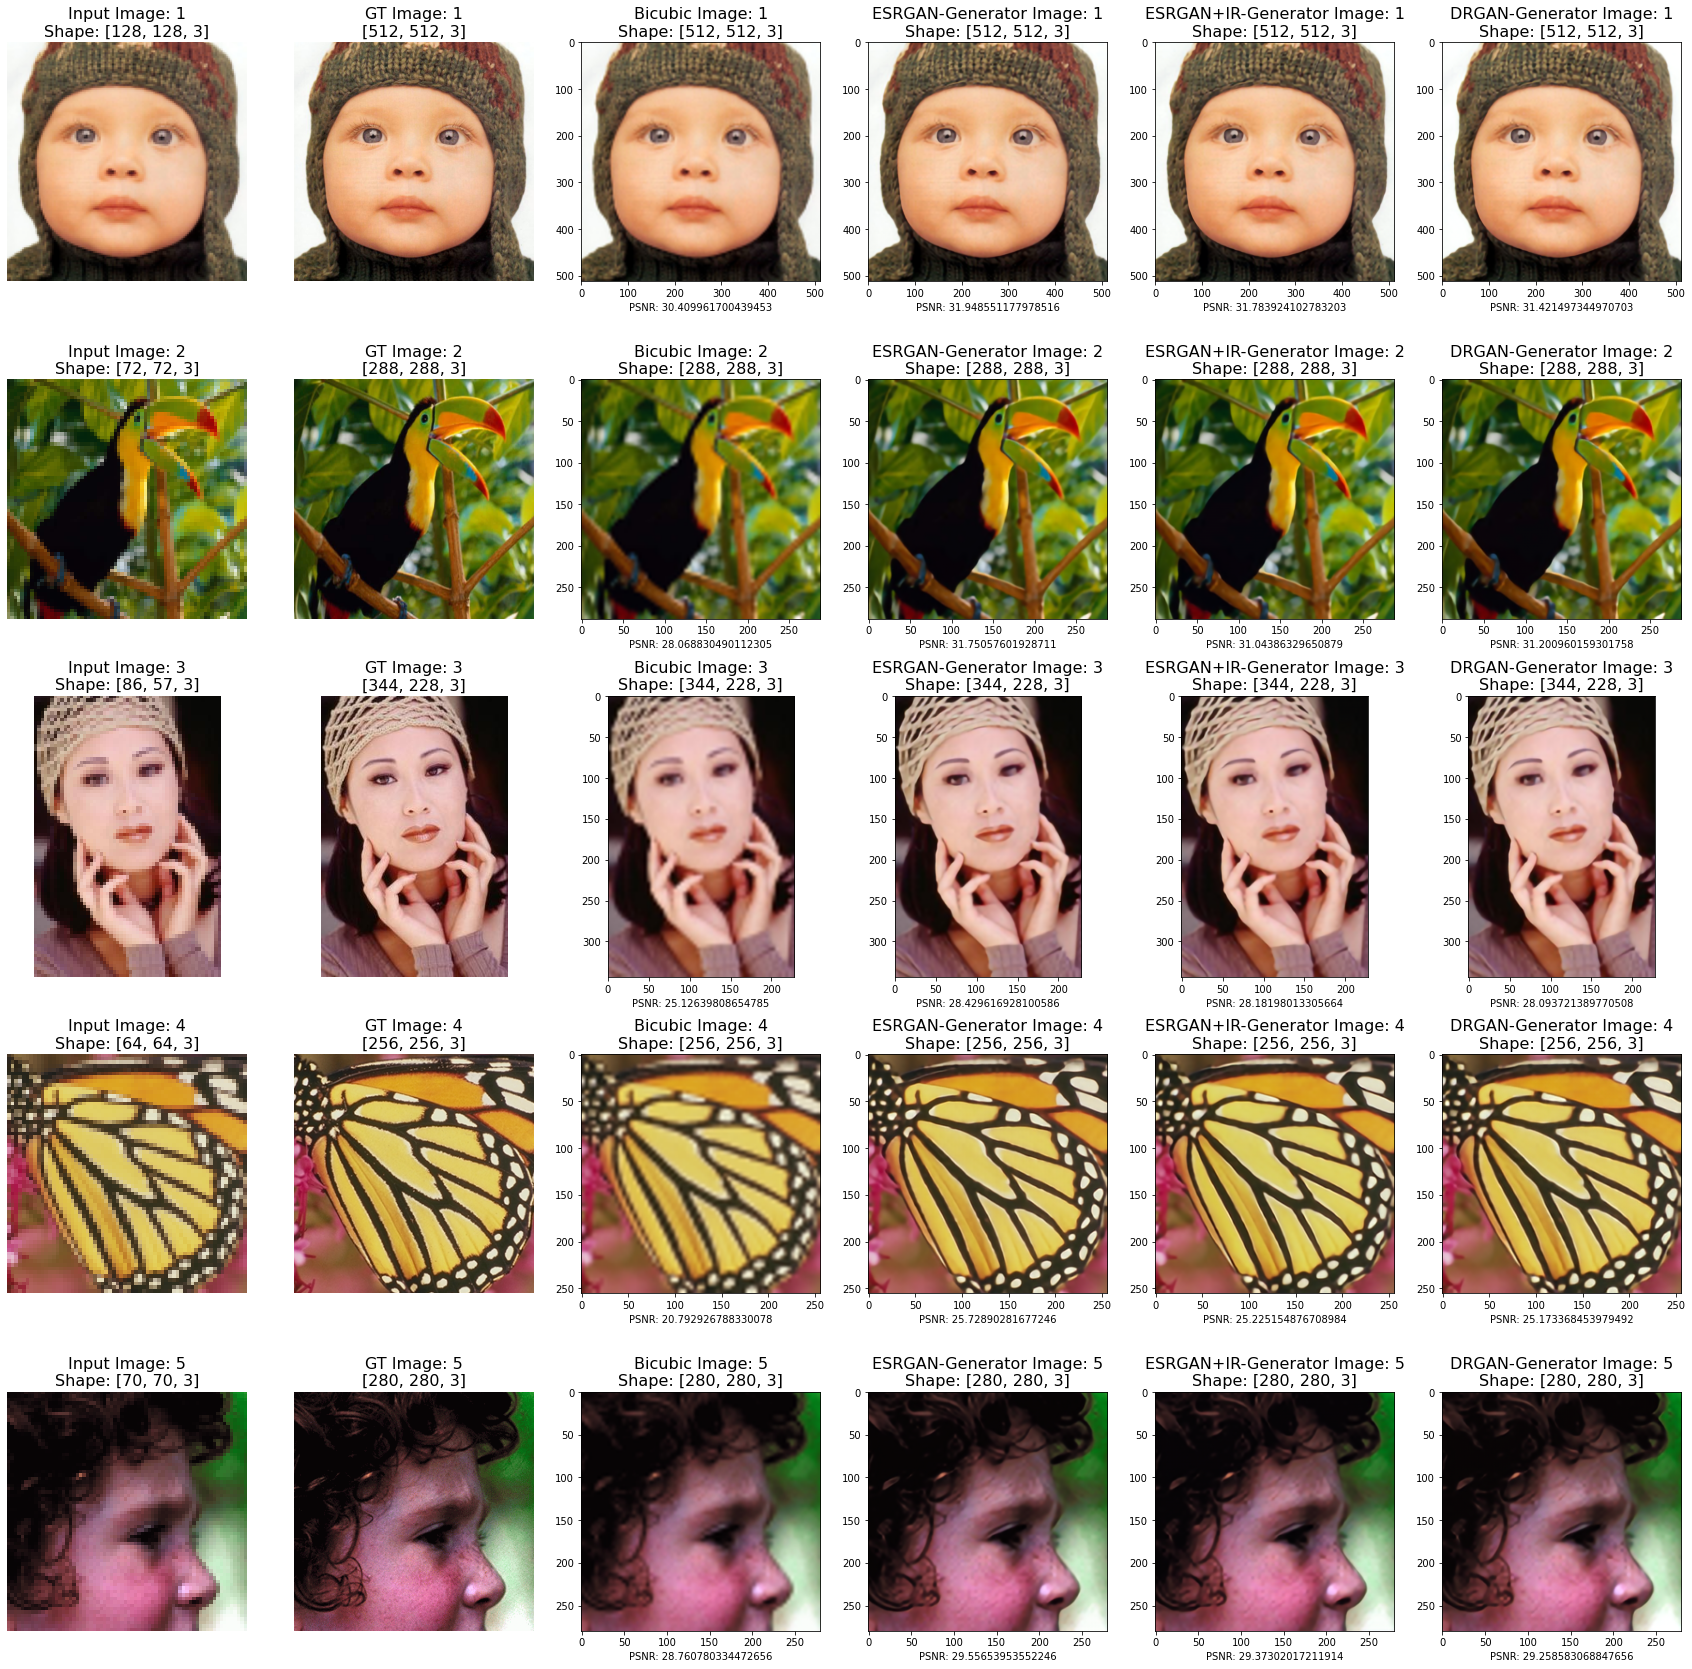

In [ ]:
#@title Results of the Generators
methods = {"ESRGAN-Generator": esrgan_generator,
           "ESRGAN+IR-Generator": esrganir_generator, 
           "DRGAN-Generator": drgan_generator }

psnr_dic = visualize_results(datasets, methods)

Regarding the GANs, the PSNR values are lower compared to the generators' performances but the GAN networks are capable of reconstructing more details (ex the freckles for *head* picture).

In particular, the ESRGAN (Baseline) stil results the best method, followed by the ESRGAN+IR and the DRGAN:

1. **ESRGAN** (Baseline) PSNR: 28.0727
2. **ESRGAN+IR** PSNR: 27.4484
3. **DRGAN** PSNR: 26.8047

Looking closely at the images generated by the different methods, there are diffent concepts to highlight:

- The ESRGAN (Baseline) outputs appear clearer than our models: this may happen because we have trained more the baseline than our implementations.
- It seems to us that each model gives to the output image a different light:
  - **ESRGAN** (Baseline): The light seems colder than the light in the Ground Truth.
  - **ESRGAN+IR**: The light seems warmer than the light in the Ground Truth (like yellowed).
  - **DRGAN**: The light seems to be the most similar to the light of the Ground Truth.
- Our models seems to have more defined details. If we look for example to the presence of the freckles in the child.

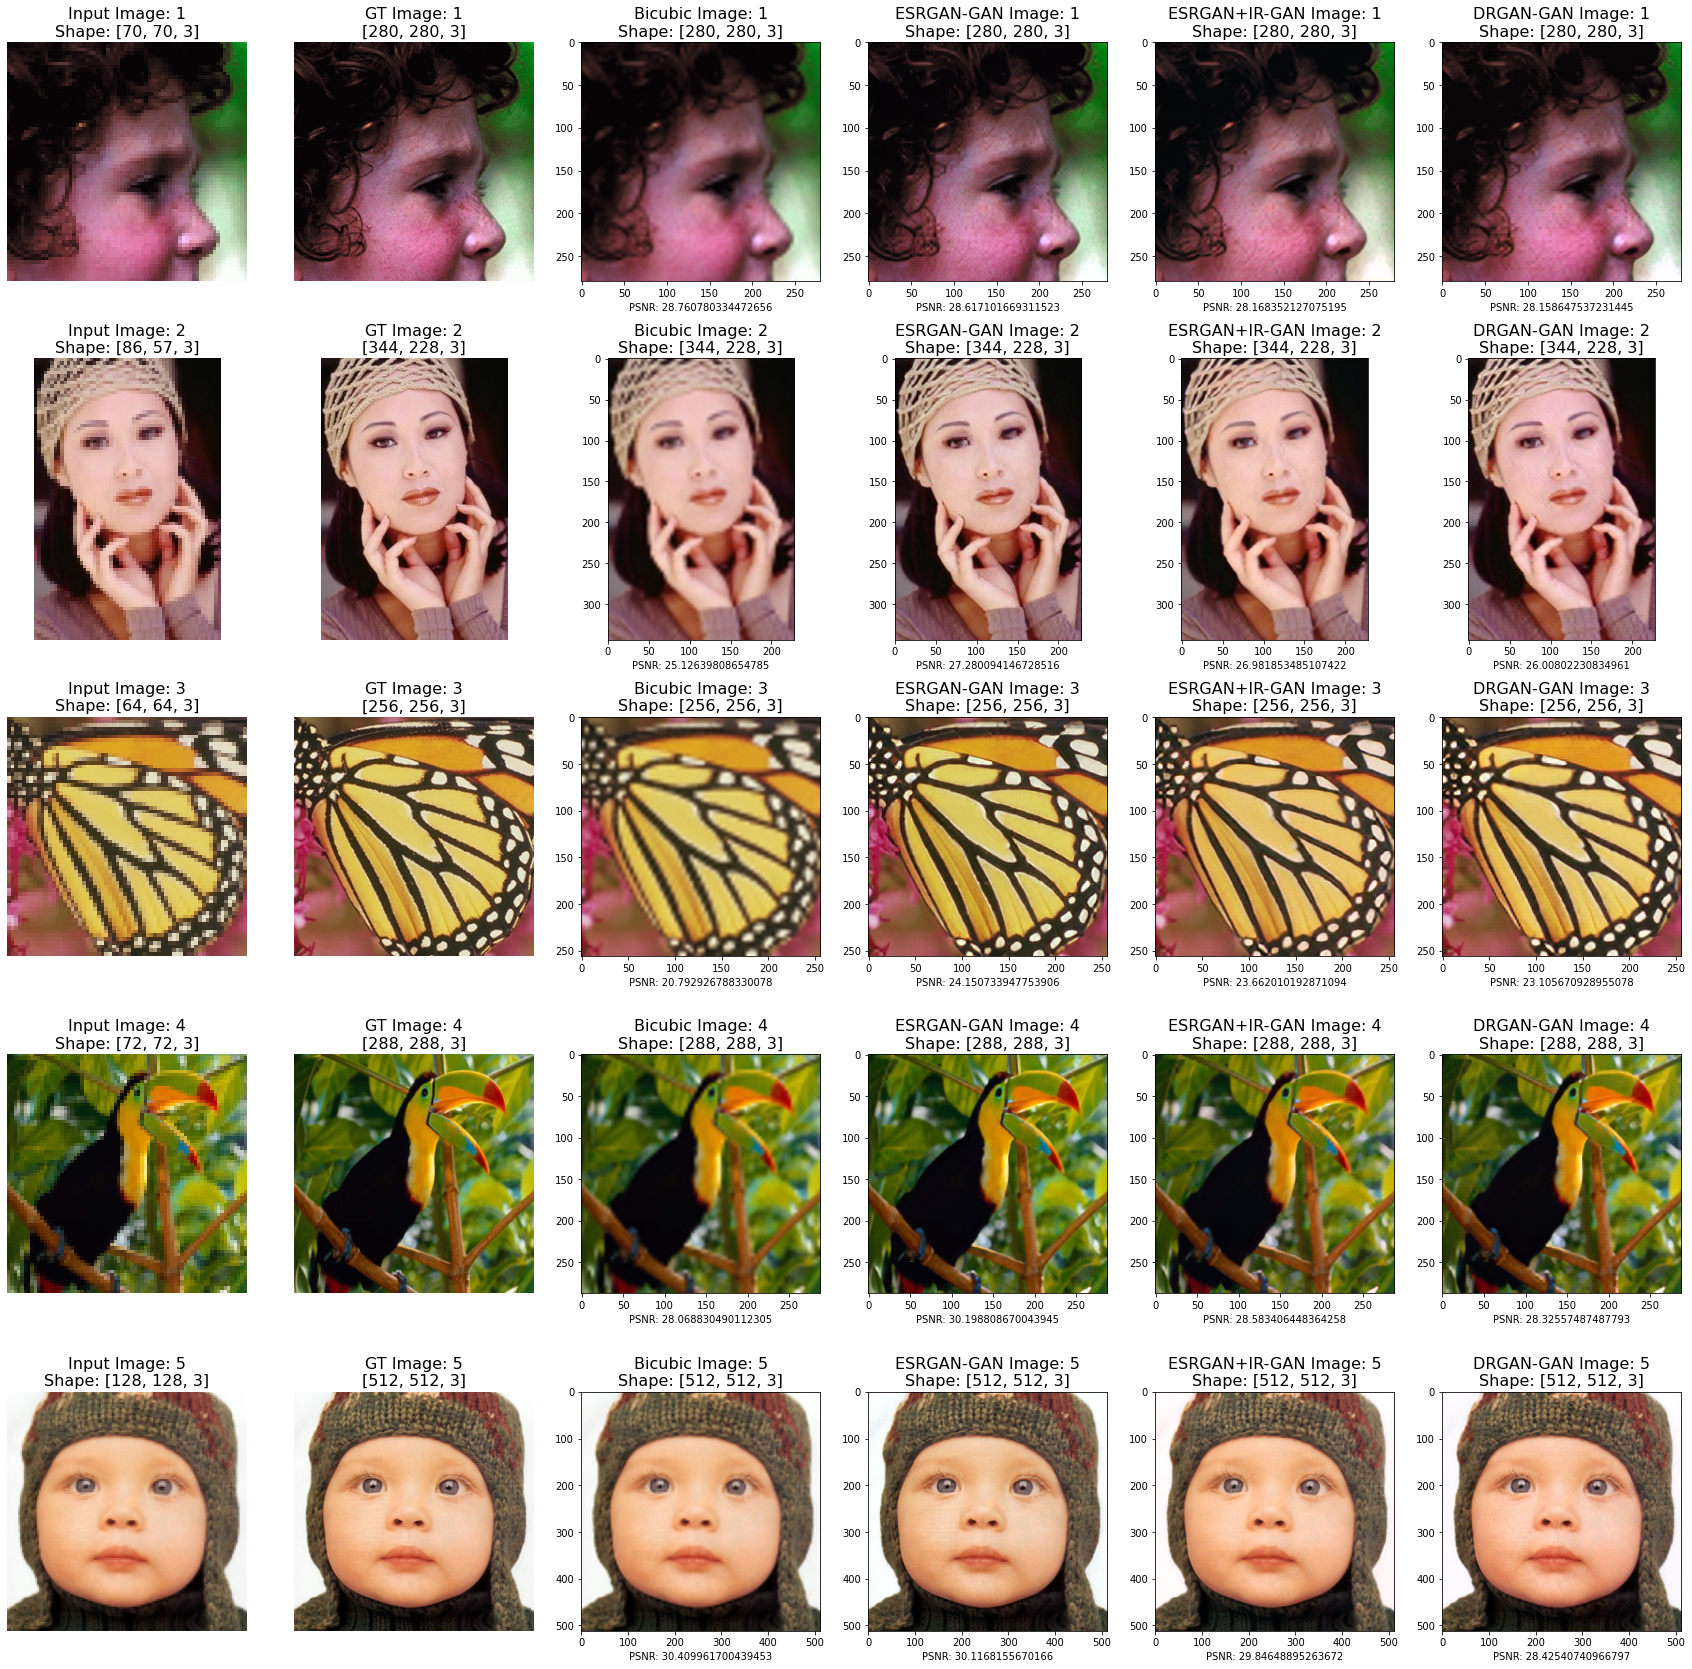

In [ ]:
#@title Results of the GANs
methods = {"ESRGAN-GAN": esrgan_gan,
           "ESRGAN+IR-GAN": esrganir_gan, 
           "DRGAN-GAN": drgan_gan }

psnr_dic = visualize_results(datasets, methods)

#Analyzing the details:

Regarding the quality of the resulting images, in particular of the ability of the models to reconstruct the small original details, the DRGAN results the most skilled one. As we can see from the following zoom in, the DRGAN is the most capable in approximating the sharpness of the butterfly's edges. 

## <center> Ground Truth - Bicubic - ESRGAN-GAN
## <center> <img src="https://drive.google.com/uc?id=1g04hbxiPJz9F-UCGiNhqp56TdkK74tZ4" width=325> <img src="https://drive.google.com/uc?id=1a5_HrE2sD9tGeNrz9A1gvl6gGCxUTkZk" width=325> <img src="https://drive.google.com/uc?id=1-sCt5Mod0JxKyZVl68U3lihHwRTJ4hNc" width=325> 


## <center> ESRGAN+IR-GAN - DRGAN-GAN 
## <center> <img src="https://drive.google.com/uc?id=1YSuNrSy1QDtZ4M1nBa2EVQuKilX1YIZO" width=325> <img src="https://drive.google.com/uc?id=1nddKbF3N6_tLlLtcosNmBD0XlPlzmkox" width=325>

What we have noticed: 

- ESRGAN+IR: The width of the black lines sees to be smaller compared to the Groud Trouth (the ESRGAN appears more accurate). In addition, some portions of the image in which there is not a strong color contrast seem very blurred. At the same time, this effect produces smoother edges. In our opinion, this is due to the convolution layers inside the IR network.

- DRGAN: It seems to be the most skilled in approximating the small details. For example, if we look at the spikes to the left, the DRGAN is the model which returns the most similar shape. The white lines seems to be more emphasized. On the right, there are black vertical lines which can be reconducted to several streaks present in the ground truth. 

Thus, taking into account these findings and the fact that our models contain more parameters than the ESRGAN, we strongly think that, with more training time, our implementations can generate even better results. We think that this statement is especially true for the DRGAN which already produces results close to the ESRGAN and, in pespective, it can generates even better details.

#Conclusions

In conclusion, considering the fact that our models have been trained for fewer epochs and they have still reached a PSNR value close to the ESRGAN baseline, we can assert that they can be consider SOTA for the Super Resolution Task. 

In summary: 
## <center> ![](https://drive.google.com/uc?id=1yhIOBZznRaGrIDZMcDtv8h5i1a6n3Z6I)

Finally, we want to make an observation. In our opinion, even if the PSNR metric is a powerfull measure in signal processing and in particular, for the Super Resolution task, it helps understanding how much the generated images are different at the level of the pixels, we think that a different evaluation metric should be used. Infact, looking at the DRGAN, it was the worst in the terms of PSNR but the most skilled one in retrieving the original small details. Moreover, considering the bicubic interpolation, even if it outputs images which are far away from the original ones, it has a PSNR value similar to all the other evaluated methods.

# Bibliography

- SRGAN https://arxiv.org/abs/1609.04802 ([PDF](https://arxiv.org/pdf/1609.04802.pdf)).
- ESRGAN https://arxiv.org/abs/1809.00219 ([PDF](https://arxiv.org/pdf/1809.00219.pdf)).
- Code for the content loss ([GitHub](https://github.com/Lornatang/ESRGAN-PyTorch/blob/61ad9177e59360bf70abc4220b128abf6f70da12/model.py#L246)).

# TEAM

Emanuele Iacobelli: [GitHub](https://github.com/IacobelliEmanuele), [Linkedin](www.linkedin.com/in/Emanuele-Iacobelli) 

Mario Edoardo Pandolfo: [GitHub](https://github.com/JRhin), [Linkedin](www.linkedin.com/in/jrhin)